## Notebook for calculating aggregated prediction, uncertainty, EI, exploitation ratio and SHAP plots

**Created on 10th August, 2023; modified on 17th April, 2024**

**Dataset: label_ecfp_pca_add_feat_082423.csv**

In [12]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
## import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, Matern, ConstantKernel, DotProduct, PairwiseKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf
import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from IPython.display import SVG, display

import json
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
# output_notebook()
import shap
import joblib

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-7


total 754096
-rw-r--r--@    1 riteshk  staff      15705 May 11  2024 just_label_iter_7.csv
-rw-r--r--@    1 riteshk  staff     941362 May 11  2024 Activelearning-batch6.xlsx
-rw-r--r--@    1 riteshk  staff      84089 May 11  2024 label_ecfp_pca_add_feat_iter_7_051124.csv
-rw-r--r--@    1 riteshk  staff  374300343 May 11  2024 unlabel_1mil_ecfp_pca_add_feat_iter_7.csv
-rw-r--r--@    1 riteshk  staff     364185 May 11  2024 pairwise_iter7_051124.pkl
-rw-r--r--@    1 riteshk  staff     364160 May 11  2024 matern_iter7_051124.pkl
-rw-r--r--@    1 riteshk  staff     364217 May 11  2024 rq_iter7_051124.pkl
-rw-r--r--@    1 riteshk  staff     364346 May 11  2024 rbfexpsin_iter7_051124.pkl
-rw-r--r--     1 riteshk  staff  687686493 May 11  2024 preds_uncer_ei_unlabel_1mil_iter7_051124.csv
-rw-r--r--@    1 riteshk  staff    1682537 May 11  2024 iter_7_top5000_sugg_ei_unique_explore.csv
-rw-r--r--@    1 riteshk  staff   35534831 May 11  2024 interactive_map_sugg_al_051124_explore.html
-rw-r--r--

In [3]:
# df_unlabel_.to_csv('unlabel_1mil_ecfp_pca_add_feat_iter_7.csv') ## save the unlabeled data for the next iteration
df_unlabel_ = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat_iter_7.csv') ## read the unlabeled data for the next iteration
# df_unlabel_

In [3]:
df = pd.read_csv('label_ecfp_pca_add_feat_iter_7_051124.csv') ## added the labeled data from the 6th iteration of suggestions to the labeled data from 4th iteration manually
df['solv_comb_sm'] = df['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,COC1CCCCC1=O,[Li+].F[P-](F)(F)(F)(F)F,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
195,COC1CCCCC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
196,COCCS(=O)(=O)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
197,COCCSC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [4]:
## Important change: on 24th August, 2023
df_ = df.copy()
df_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,COC1CCCCC1=O,[Li+].F[P-](F)(F)(F)(F)F,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
195,COC1CCCCC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
196,COCCS(=O)(=O)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
197,COCCSC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [5]:
df_.loc[df_['mol_wt_salt'] == 186.939685][['salt_comb_sm', 'mol_wt_salt', 'norm_capacity_3']]

,salt_comb_sm,mol_wt_salt,norm_capacity_3


In [59]:
df_.loc[df_['mol_wt_solv'] >= 300][['solv_comb_sm', 'mol_wt_solv', 'norm_capacity_3']]

,solv_comb_sm,mol_wt_solv,norm_capacity_3
16,FC(F)(F)COCCOCCOCCOCC(F)(F)F,314.095278,0.477793
109,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)F)(OC)OC,318.052218,0.010000
146,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,468.042638,0.000000
147,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,468.042638,0.000000
148,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,468.042638,0.000000


In [54]:
df_['mol_wt_salt'].unique()
df_['salt_comb_sm'].unique()

array(['O=S(=O)(F)[N-]S(=O)(=O)F.[Li+]',
       'O=C1O[B-](F)(F)OC1=O.O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].[Li+]',
       'F[B-](F)(F)F.O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].[Li+]',
       '[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F', '[Li+].F[P-](F)(F)(F)(F)F',
       '[Li+].O=C1O[B-](F)(F)OC1=O'], dtype=object)

In [55]:
df_.loc[df_['salt_comb_sm'] == '[Li+].F[P-](F)(F)(F)(F)F']['mol_wt_salt']
df_.loc[df_['salt_comb_sm'] == '[Li+].O=C1O[B-](F)(F)OC1=O']['mol_wt_salt']
# df_.loc[df_['salt_comb_sm'] == '[Li+].F[P-](F)(F)(F)(F)F']['mol_wt_salt']

62     144.001775
65     144.001775
68     144.001775
72     144.001775
75     144.001775
79     144.001775
82     144.001775
85     144.001775
88     144.001775
91     144.001775
94     144.001775
97     144.001775
100    144.001775
103    144.001775
108    144.001775
113    144.001775
116    144.001775
119    144.001775
126    144.001775
129    144.001775
133    144.001775
136    144.001775
140    144.001775
145    144.001775
148    144.001775
151    144.001775
154    144.001775
157    144.001775
160    144.001775
163    144.001775
166    144.001775
169    144.001775
172    144.001775
175    144.001775
178    144.001775
182    144.001775
189    144.001775
195    144.001775
198    144.001775
Name: mol_wt_salt, dtype: float64

In [90]:
amt_ind = df_['amt_electrolyte'].sort_values(ascending=False).index
df_.iloc[amt_ind][['solv_comb_sm', 'mol_wt_salt', 'amt_electrolyte', 'norm_capacity_3']]

,solv_comb_sm,mol_wt_salt,amt_electrolyte,norm_capacity_3
0,COCCOC,186.939685,50,0.276580
125,COCCN(C)C,186.939685,50,0.000007
127,CCOCCCl,186.939685,50,0.000000
128,CCOCCCl,151.980186,50,0.000000
129,CCOCCCl,144.001775,50,0.000000
...,...,...,...,...
37,COCCOCC(F)(F)C(F)(F)F,186.939685,13,0.000009
36,COCCOCC(F)(F)C(F)(F)F,280.958608,13,0.097532
35,COCCOCC(F)(F)C(F)(F)F,186.939685,13,0.743032
34,COCCOCC(F)(F)C(F)(F)F,330.941460,13,0.000522


In [95]:
cap_ind = df_['theor_capacity'].sort_values(ascending=False).index
list(df_[['solv_comb_sm', 'mol_wt_salt', 'theor_capacity', 'norm_capacity_3']].value_counts().index)

[('CC1(C(=O)Cl)CCCCC1', 144.0017749, 150, 0.0),
 ('COCCOC', 186.9396855, 150, 0.635333333),
 ('COCCOC', 186.9396855, 150, 0.709666667),
 ('COCCOC', 186.9396855, 203, 0.761182266),
 ('COCCOC(C)(C)C', 186.9396855, 150, 0.276148),
 ('COCCOC(C)C', 186.9396855, 150, 0.66146),
 ('COCCOC(C)C', 186.9396855, 150, 0.7302),
 ('COCCOC(C)C', 186.9396855, 150, 0.745733333),
 ('COCCOC1CCCC1', 186.9396855, 150, 0.46594),
 ('COCCOCC(=O)OC', 144.0017749, 150, 6.67e-05),
 ('COCCOCC(=O)OC', 151.9801855, 150, 6.67e-05),
 ('COCCOCC(=O)OC', 186.9396855, 150, 6.67e-05),
 ('COCCOCC(C)C', 186.9396855, 150, 0.178386667),
 ('COCCOCC(C)C', 186.9396855, 150, 0.216953333),
 ('COCCOCC(F)(F)C(F)(F)F', 186.9396855, 150, 0.652766667),
 ('COCCOCC(F)(F)C(F)(F)F', 186.9396855, 150, 0.68484),
 ('COCCOCC(F)(F)C(F)(F)F', 186.9396855, 150, 0.700846667),
 ('COCCOCC(F)(F)C(F)(F)F', 186.9396855, 150, 0.75172),
 ('COCCOCC(F)(F)C(F)(F)F', 186.9396855, 150, 0.770546667),
 ('COCCOCC(F)(F)C(F)(F)F', 186.9396855, 150, 0.776418667),
 ('

In [96]:
df_.loc[df_['theor_capacity'] == 203][['solv_comb_sm', 'mol_wt_salt', 'theor_capacity', 'norm_capacity_3']]

,solv_comb_sm,mol_wt_salt,theor_capacity,norm_capacity_3
33,COCCOCC(F)(F)C(F)(F)F,186.939685,203,0.736066
34,COCCOCC(F)(F)C(F)(F)F,330.941460,203,0.000522
35,COCCOCC(F)(F)C(F)(F)F,186.939685,203,0.743032
36,COCCOCC(F)(F)C(F)(F)F,280.958608,203,0.097532
37,COCCOCC(F)(F)C(F)(F)F,186.939685,203,0.000009
38,COCCOCC(F)(F)C(F)(F)F,186.939685,203,0.626675
39,COCCOCC(F)(F)C(F)F,186.939685,203,0.612006
40,COCCOCC(F)(F)C(F)F,186.939685,203,0.642517
56,CCS(=O)(=O)F,186.939685,203,0.718571
57,COCCOC,186.939685,203,0.761182


In [14]:
X = df_.iloc[:,2:27]
y = df_['norm_capacity_3']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## will be using complete dataset for training
# X_test
X

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,-0.780469,-0.407588,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,90.068080,186.939685,1.0,150,50
1,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,118.099380,186.939685,1.0,150,50
2,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
3,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,146.130680,186.939685,2.2,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,128.083730,151.980186,1.0,150,50
195,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,128.083730,144.001775,1.0,150,50
196,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,-1.061449,-0.608401,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,142.009993,186.939685,1.0,150,50
197,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,-0.907013,-0.467004,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,106.045236,186.939685,1.0,150,50


In [22]:
std_scale_ = StandardScaler().fit(X)
X_std = std_scale_.transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [8]:
# df_unlabel = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat.csv')
# df_unlabel_ = df_unlabel.copy()
df_unlabel_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_unlabel_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1,150,50
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1,150,50
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1,150,50
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1,150,50
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,193.077264,144.001775,1,150,50
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,240.147392,144.001775,1,150,50
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,251.046358,144.001775,1,150,50
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,248.133634,144.001775,1,150,50


In [9]:
# uniq_smiles = df_unlabel_['smiles'].unique()
df_unlabel_uniq = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_unlabel_uniq

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1,150,50
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1,150,50
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1,150,50
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1,150,50
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999811,999872,999899,999915,999946,999984,CCCCN1C(=O)OCC1[SiH](C)C,[Li+].O=C1O[B-](F)(F)OC1=O,0.627609,-0.998588,-0.085111,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,201.118505,144.001775,1,150,50
999813,999874,999901,999917,999948,999986,CC(C)(C)C(=O)N1C2CCC1COC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.902927,0.033572,0.856049,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,197.141579,144.001775,1,150,50
999814,999875,999902,999918,999949,999987,CC(C)(C)C(=O)CS(=O)(=O)CC(=O)N1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.621175,0.407378,0.570353,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,275.119129,144.001775,1,150,50
999815,999876,999903,999919,999950,999988,CCO[Si](CCC(C)SC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.112749,-1.140740,0.140488,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,238.105892,144.001775,1,150,50


In [9]:
# df_unlabel_.drop(columns=['Unnamed: 0'], inplace=True)
X_un = df_unlabel_.iloc[:,7:] ## change it for every new iteration
X_un_std = std_scale_.transform(X_un)
X_un_std = pd.DataFrame(X_un_std, columns=X_un.columns)
# X_std = std_scale_.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
X_un_std

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0.189971,0.522984,-2.384489,-0.251395,1.921232,-0.583037,-0.892321,0.042383,-1.134547,0.309934,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-1.436471,0.585522,-0.259754,-0.26585,0.19753
1,1.885197,0.623655,-0.099303,1.634960,1.410758,-2.588613,-0.360440,1.314070,-1.163256,0.259675,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-0.692647,0.585522,-0.259754,-0.26585,0.19753
2,-0.121483,2.530338,-2.007775,-0.198407,2.648947,-0.785415,-1.079594,-0.057542,-1.111984,0.360352,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-0.656103,0.585522,-0.259754,-0.26585,0.19753
3,0.408186,-0.285855,-0.260020,0.193311,1.505732,-1.221817,-0.804286,-0.214497,-1.684152,0.339244,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-1.490749,0.585522,-0.259754,-0.26585,0.19753
4,0.243236,0.609397,-2.475250,-0.549502,1.958126,-0.881289,-0.865091,0.136632,-1.213444,0.303851,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-1.454743,0.585522,-0.259754,-0.26585,0.19753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,1.577695,0.202391,-0.415057,0.758894,1.276019,-1.724635,-0.731876,0.005536,-2.118801,2.073269,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,0.739610,-1.247067,-0.259754,-0.26585,0.19753
999822,1.717854,3.627507,2.485982,0.912929,0.297736,-1.188778,-0.992278,2.608588,2.075815,-1.213686,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,1.593006,-1.247067,-0.259754,-0.26585,0.19753
999823,1.489033,3.553677,1.671585,1.768694,-0.034841,-0.424615,-0.121227,-1.040774,-0.340320,1.499419,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,1.790608,-1.247067,-0.259754,-0.26585,0.19753
999824,1.308379,4.158492,-2.292695,-0.869240,1.546993,1.308633,-1.536579,-0.064226,0.634029,-0.566274,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,1.737799,-1.247067,-0.259754,-0.26585,0.19753


In [12]:
## final corrected & verified one to be used
def EI_(y_pred, y_pred_un, y_pred_un_uncer, epsilon=0.01):
    y_best = np.max(y_pred)
    EI = []
    explore = []
    exploit = []

    for i in range(len(y_pred_un)):
        if y_pred_un_uncer[i] != 0:
            # Calculate the cumulative distribution function (CDF) for the Gaussian distribution
            z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            # z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            cdf_z = 0.5 * (1 + erf(z / np.sqrt(2)))
            pdf_z = np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

            # Calculate the probability of improvement
            # probability_improvement = y_pred_un_uncer[i] * (z * cdf_z + np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi))

            # Calculate Expected Improvement
            expected_improvement = y_pred_un_uncer[i] * (z * cdf_z) + y_pred_un_uncer[i] * pdf_z
            exploitation = y_pred_un_uncer[i] * z * cdf_z
            exploration = y_pred_un_uncer[i] * pdf_z
            EI.append(expected_improvement)
            explore.append(exploration)
            exploit.append(exploitation)
        else:
            EI.append(0.0)
    return EI, exploit, explore

### Save aggregate prediction, uncertainty, EI, exploitation & exploration values

In [23]:
# Calculate Model Weights using BMA (first order)
model_names = ['pairwise_iter7_051124.pkl', 'matern_iter7_051124.pkl', 'rq_iter7_051124.pkl', 'rbfexpsin_iter7_051124.pkl']
model_weights = []
uncertainties = []
predictions = []
y_label_preds = []
for model in model_names:
    gpr = pickle.load(open(model, 'rb'))
    # y_un = gpr.predict(X_un_std)
    # predictions.append(y_un)
    # individual_uncertainties = gpr.predict(X_un_std, return_std=True)[1]
    # uncertainties.append(individual_uncertainties)
    # likelihoods = norm.pdf(y_un, loc=gpr.predict(X_un_std), scale=individual_uncertainties)
    # prior_beliefs = 1.0  # Non-informative prior
    # posterior = likelihoods * prior_beliefs
    # model_weights.append(posterior / np.sum(posterior))
    y_ = gpr.predict(X_std)
    y_label_preds.append(y_)

In [14]:
df_unlabel_['uncertainty_1'] = uncertainties[0]; df_unlabel_['uncertainty_2'] = uncertainties[1]; df_unlabel_['uncertainty_3'] = uncertainties[2]; df_unlabel_['uncertainty_4'] = uncertainties[3]
df_unlabel_['prediction_1'] = predictions[0]; df_unlabel_['prediction_2'] = predictions[1]; df_unlabel_['prediction_3'] = predictions[2]; df_unlabel_['prediction_4'] = predictions[3]
df_unlabel_['explore_1'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])[2]; df_unlabel_['exploit_1'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])[1]; # df_unlabel_['ratio_1'] = df_unlabel_['exploit_1'] / (df_unlabel_['explore_1'] + df_unlabel_['exploit_1'])
df_unlabel_['explore_2'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])[2]; df_unlabel_['exploit_2'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])[1]; # df_unlabel_['ratio_2'] = df_unlabel_['exploit_2'] / (df_unlabel_['explore_2'] + df_unlabel_['exploit_2'])
df_unlabel_['explore_3'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])[2]; df_unlabel_['exploit_3'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])[1]; # df_unlabel_['ratio_3'] = df_unlabel_['exploit_3'] / (df_unlabel_['explore_3'] + df_unlabel_['exploit_3'])
df_unlabel_['explore_4'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])[2]; df_unlabel_['exploit_4'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])[1]; # df_unlabel_['ratio_4'] = df_unlabel_['exploit_4'] / (df_unlabel_['explore_4'] + df_unlabel_['exploit_4'])
df_unlabel_['EI_1'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])[0]; df_unlabel_['EI_2'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])[0]; df_unlabel_['EI_3'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])[0]; df_unlabel_['EI_4'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])[0]
# df_unlabel_['ratio'] = df_unlabel_['ratio_1'] * model_weights[0] + df_unlabel_['ratio_2'] * model_weights[1] + df_unlabel_['ratio_3'] * model_weights[2] + df_unlabel_['ratio_4'] * model_weights[3]
# df_unlabel_['EI_aggr'] = df_unlabel_['EI_1'] * model_weights[0] + df_unlabel_['EI_2'] * model_weights[1] + df_unlabel_['EI_3'] * model_weights[2] + df_unlabel_['EI_4'] * model_weights[3]
df_unlabel_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,explore_2,exploit_2,explore_3,exploit_3,explore_4,exploit_4,EI_1,EI_2,EI_3,EI_4
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.000024,-0.000022,0.000105,-0.000099,2.306467e-06,-2.209764e-06,5.558162e-07,1.240826e-06,0.000007,9.670306e-08
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.000035,-0.000033,0.000113,-0.000106,1.460620e-05,-1.388329e-05,1.075332e-06,1.891838e-06,0.000007,7.229094e-07
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.000008,-0.000008,0.000079,-0.000074,6.959799e-07,-6.695764e-07,1.044421e-07,3.739091e-07,0.000005,2.640350e-08
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.000072,-0.000068,0.000120,-0.000112,1.171582e-05,-1.114430e-05,2.954488e-06,4.279159e-06,0.000008,5.715265e-07
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.000022,-0.000021,0.000115,-0.000108,1.290839e-06,-1.239287e-06,4.897230e-07,1.155365e-06,0.000007,5.155232e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,0.000007,-0.000006,0.000079,-0.000074,3.396133e-07,-3.274353e-07,3.898570e-08,3.090369e-07,0.000005,1.217796e-08
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,0.000067,-0.000063,0.000347,-0.000322,2.931206e-05,-2.776789e-05,4.190717e-07,3.851784e-06,0.000025,1.544176e-06
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,0.000048,-0.000045,0.000279,-0.000260,1.155072e-05,-1.099605e-05,3.834876e-07,2.683026e-06,0.000020,5.546731e-07
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,0.000033,-0.000032,0.000425,-0.000393,6.037935e-06,-5.766569e-06,4.490211e-08,1.769142e-06,0.000031,2.713660e-07


In [15]:
def calc_aggr_uncer(uncer_1, w_1, pred_1, uncer_2, w_2, pred_2, uncer_3, w_3, pred_3, uncer_4, w_4, pred_4):
    uncer = [uncer_1, uncer_2, uncer_3, uncer_4]
    pred = [pred_1, pred_2, pred_3, pred_4]
    weight = [w_1, w_2, w_3, w_4]
    pred_aggr = w_1 * pred_1 + w_2 * pred_2 + w_3 * pred_3 + w_4 * pred_4
    sum = 0
    for i in range(4):
        sum += weight[i] * (uncer[i]**2 + (pred[i] - pred_aggr)**2)
    aggr_uncer = np.sqrt(sum)
    # for i in range(len(uncer_1)):
    #     aggr_uncer.append((uncer_1[i] * w_1[i] + uncer_2[i] * w_2[i] + uncer_3[i] * w_3[i] + uncer_4[i] * w_4[i]) / 4)
    return aggr_uncer

In [16]:
df_unlabel_['prediction_aggr'] = df_unlabel_['prediction_1'] * model_weights[0] + df_unlabel_['prediction_2'] * model_weights[1] + df_unlabel_['prediction_3'] * model_weights[2] + df_unlabel_['prediction_4'] * model_weights[3]
df_unlabel_['uncertainty_aggr'] = calc_aggr_uncer(df_unlabel_['uncertainty_1'], model_weights[0], df_unlabel_['prediction_1'], df_unlabel_['uncertainty_2'], model_weights[1], df_unlabel_['prediction_2'], df_unlabel_['uncertainty_3'], model_weights[2], df_unlabel_['prediction_3'], df_unlabel_['uncertainty_4'], model_weights[3], df_unlabel_['prediction_4'])
df_unlabel_['explore_aggr'] = df_unlabel_['explore_1'] * model_weights[0] + df_unlabel_['explore_2'] * model_weights[1] + df_unlabel_['explore_3'] * model_weights[2] + df_unlabel_['explore_4'] * model_weights[3]
df_unlabel_['exploit_aggr'] = df_unlabel_['exploit_1'] * model_weights[0] + df_unlabel_['exploit_2'] * model_weights[1] + df_unlabel_['exploit_3'] * model_weights[2] + df_unlabel_['exploit_4'] * model_weights[3]
df_unlabel_['EI_aggr'] = df_unlabel_['EI_1'] * model_weights[0] + df_unlabel_['EI_2'] * model_weights[1] + df_unlabel_['EI_3'] * model_weights[2] + df_unlabel_['EI_4'] * model_weights[3]
# df_unlabel_['ratio'] = df_unlabel_['exploit'] / (df_unlabel_['explore'] + df_unlabel_['exploit'])
# df_unlabel_['ratio'] = df_unlabel_['exploit'] / (df_unlabel_['explore'])
df_unlabel_['ratio_aggr'] = df_unlabel_['exploit_aggr'] / df_unlabel_['EI_aggr']
# df_unlabel_['ratio_std'] = MinMaxScaler().fit_transform(df_unlabel_['ratio'].values.reshape(-1,1))
df_unlabel_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,EI_1,EI_2,EI_3,EI_4,prediction_aggr,uncertainty_aggr,explore_aggr,exploit_aggr,EI_aggr,ratio_aggr
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,5.558162e-07,1.240826e-06,0.000007,9.670306e-08,-4.709601e-08,0.000458,1.614079e-10,-1.517531e-10,9.654864e-12,-15.717786
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,1.075332e-06,1.891838e-06,0.000007,7.229094e-07,-4.442540e-08,0.000462,1.965514e-10,-1.849416e-10,1.160980e-11,-15.929774
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,1.044421e-07,3.739091e-07,0.000005,2.640350e-08,-4.902315e-07,0.000530,9.461644e-11,-8.910186e-11,5.514583e-12,-16.157498
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,2.954488e-06,4.279159e-06,0.000008,5.715265e-07,3.816853e-07,0.000478,3.002380e-10,-2.819075e-10,1.833054e-11,-15.379111
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,4.897230e-07,1.155365e-06,0.000007,5.155232e-08,-1.330196e-07,0.000467,1.651111e-10,-1.551081e-10,1.000300e-11,-15.506151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,3.898570e-08,3.090369e-07,0.000005,1.217796e-08,-7.473390e-07,0.000613,8.533438e-11,-8.036894e-11,4.965443e-12,-16.185651
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,4.190717e-07,3.851784e-06,0.000025,1.544176e-06,-3.374611e-07,0.000519,4.184999e-10,-3.900316e-10,2.846834e-11,-13.700536
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,3.834876e-07,2.683026e-06,0.000020,5.546731e-07,-3.363119e-07,0.000511,3.320177e-10,-3.098517e-10,2.216600e-11,-13.978691
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,4.490211e-08,1.769142e-06,0.000031,2.713660e-07,-6.854201e-07,0.000623,4.117489e-10,-3.821994e-10,2.954952e-11,-12.934199


In [17]:
df_b7_explor = pd.read_csv('iter_7_top5000_sugg_ei_unique_explore.csv')
df_b7_explor

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_7th_7,578.0
4483,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_7th_7,4264.0
4484,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_7th_5,3241.0
4485,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_7th_8,2496.0


In [18]:
df_b7_explor_ = df_b7_explor.merge(df_unlabel_[['solv_comb_sm', 'salt_comb_sm', 'prediction_aggr', 'uncertainty_aggr', 'explore_aggr', 'exploit_aggr', 'ratio_aggr', 'EI_aggr']], on=['solv_comb_sm', 'salt_comb_sm'], how='left')
df_b7_explor_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,TSNE_0,TSNE_1,database,rank,prediction_aggr,uncertainty_aggr,explore_aggr,exploit_aggr,ratio_aggr,EI_aggr
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,14.868960,35.267883,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,26.357819,-1.480546,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,22.556498,28.949097,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,-27.672503,6.123165,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,-3.126033,34.261627,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,-21.946915,-9.196156,sugg_7th_7,578.0,1.475336e-06,0.000844,2.328477e-08,-2.005211e-08,-6.202975,3.232660e-09
4483,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,-21.917328,-9.234112,sugg_7th_7,4264.0,1.261659e-06,0.000746,7.986280e-09,-7.167233e-09,-8.750702,8.190466e-10
4484,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,28.366770,-27.364807,sugg_7th_5,3241.0,1.343082e-06,0.000768,9.079260e-09,-8.082776e-09,-8.111294,9.964841e-10
4485,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,-25.198235,1.801201,sugg_7th_8,2496.0,8.901077e-07,0.000652,1.066601e-08,-9.463832e-09,-7.872218,1.202181e-09


In [19]:
df_b7_explor_.drop(index=df_b7_explor_.loc[df_b7_explor_['database'] == 'label'].index, inplace=True)
df_b7_explor_.drop(columns=['TSNE_0', 'TSNE_1', 'database'], inplace=True)
df_b7_explor_.reset_index(drop=True, inplace=True)
df_b7_explor_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,theor_capacity,amt_electrolyte,pressure_type,rank,prediction_aggr,uncertainty_aggr,explore_aggr,exploit_aggr,ratio_aggr,EI_aggr
0,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,150,50,2,1608.0,1.768582e-06,0.000909,1.375098e-08,-1.214112e-08,-7.541743,1.609856e-09
1,COCCO[Al],[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.843809,-0.989662,1.069399,-0.365416,-0.311995,0.308275,0.678411,0.599304,...,150,50,2,1920.0,1.769618e-06,0.000908,1.251228e-08,-1.110397e-08,-7.884586,1.408313e-09
2,COCCB=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801731,-1.105580,1.083006,-0.354707,-0.315271,0.212797,0.668411,0.618927,...,150,50,2,1897.0,1.749084e-06,0.000903,1.270709e-08,-1.128760e-08,-7.951840,1.419495e-09
3,COCCOOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.867386,-1.041068,1.083540,-0.400942,-0.225466,0.304233,0.783784,0.599485,...,150,50,2,1190.0,1.899484e-06,0.000960,1.682915e-08,-1.482300e-08,-7.388799,2.006145e-09
4,COCCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.046620,-1.064656,0.993638,-0.042687,-0.413475,0.534219,0.629863,0.690217,...,150,50,2,1334.0,1.772658e-06,0.000915,1.549996e-08,-1.364090e-08,-7.337516,1.859062e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,150,50,2,578.0,1.475336e-06,0.000844,2.328477e-08,-2.005211e-08,-6.202975,3.232660e-09
4342,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,150,50,2,4264.0,1.261659e-06,0.000746,7.986280e-09,-7.167233e-09,-8.750702,8.190466e-10
4343,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,150,50,2,3241.0,1.343082e-06,0.000768,9.079260e-09,-8.082776e-09,-8.111294,9.964841e-10
4344,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,150,50,2,2496.0,8.901077e-07,0.000652,1.066601e-08,-9.463832e-09,-7.872218,1.202181e-09


In [20]:
df_b7_exploit = pd.read_csv('iter_7_top5000_sugg_ei_unique_exploit.csv')
df_b7_exploit

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132,COCCCS(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.854245,-1.533978,0.921179,-0.305305,-0.172969,0.520020,1.193371,0.510727,...,1.0,0.0,150,50,2,31.906532,-3.521527,exploit_8,0.279934,4361.0
5133,CCCOCCOCCCOCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.877738,-1.596169,0.522391,0.412222,-0.835663,1.200644,0.817318,0.236686,...,1.0,0.0,150,50,2,-35.143620,5.230699,exploit_3,0.286137,3905.0
5134,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,1.0,0.0,150,50,2,-21.946915,-9.196156,exploit_9,0.341674,1358.0
5135,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,1.0,0.0,150,50,2,-21.917328,-9.234112,exploit_9,0.281449,4240.0


In [21]:
df_b7_exploit_ = df_b7_exploit.merge(df_unlabel_[['solv_comb_sm', 'salt_comb_sm', 'prediction_aggr', 'uncertainty_aggr', 'explore_aggr', 'exploit_aggr', 'ratio_aggr', 'EI_aggr']], on=['solv_comb_sm', 'salt_comb_sm'], how='left')
df_b7_exploit_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,TSNE_1,database,norm_capacity_3_avg_pred,rank,prediction_aggr,uncertainty_aggr,explore_aggr,exploit_aggr,ratio_aggr,EI_aggr
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,35.267883,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,-1.480546,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,28.949097,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,6.123165,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,34.261627,label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132,COCCCS(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.854245,-1.533978,0.921179,-0.305305,-0.172969,0.520020,1.193371,0.510727,...,-3.521527,exploit_8,0.279934,4361.0,0.000001,0.000749,4.680737e-09,-4.262400e-09,-10.188921,4.183368e-10
5133,CCCOCCOCCCOCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.877738,-1.596169,0.522391,0.412222,-0.835663,1.200644,0.817318,0.236686,...,5.230699,exploit_3,0.286137,3905.0,0.000001,0.000753,9.740583e-09,-8.683015e-09,-8.210357,1.057569e-09
5134,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,-9.196156,exploit_9,0.341674,1358.0,0.000001,0.000844,2.328477e-08,-2.005211e-08,-6.202975,3.232660e-09
5135,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,-9.234112,exploit_9,0.281449,4240.0,0.000001,0.000746,7.986280e-09,-7.167233e-09,-8.750702,8.190466e-10


In [22]:
df_b7_exploit_.drop(index=df_b7_exploit_.loc[df_b7_exploit_['database'] == 'label'].index, inplace=True)
df_b7_exploit_.drop(columns=['TSNE_0', 'TSNE_1', 'database'], inplace=True)
df_b7_exploit_.reset_index(drop=True, inplace=True)
df_b7_exploit_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,amt_electrolyte,pressure_type,norm_capacity_3_avg_pred,rank,prediction_aggr,uncertainty_aggr,explore_aggr,exploit_aggr,ratio_aggr,EI_aggr
0,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,50,2,0.361556,963.0,0.000002,0.000909,1.375098e-08,-1.214112e-08,-7.541743,1.609856e-09
1,CCCOOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.920924,-1.603036,0.550274,0.249128,-0.250719,0.486272,0.282188,0.202565,...,50,2,0.272308,4969.0,0.000001,0.000742,4.638333e-09,-4.199308e-09,-9.565083,4.390247e-10
2,[CH2]CCOOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.653605,-1.424194,0.878123,-0.406314,-0.163474,0.121483,0.449710,0.405105,...,50,2,0.319932,2059.0,0.000002,0.000828,7.006357e-09,-6.317582e-09,-9.172202,6.887748e-10
3,COP(=O)(OC)OCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.621001,-1.115459,1.065245,-0.408802,0.071975,0.005767,0.326389,0.238781,...,50,2,0.282854,4145.0,0.000001,0.000760,4.322256e-09,-3.928531e-09,-9.977869,3.937245e-10
4,CCOP(=O)(OCC)OCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.104998,-0.671211,1.004061,0.135798,-0.179604,0.467863,0.406747,0.484254,...,50,2,0.276050,4683.0,0.000001,0.000747,4.879251e-09,-4.410976e-09,-9.419622,4.682753e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,COCCCS(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.854245,-1.533978,0.921179,-0.305305,-0.172969,0.520020,1.193371,0.510727,...,50,2,0.279934,4361.0,0.000001,0.000749,4.680737e-09,-4.262400e-09,-10.188921,4.183368e-10
4992,CCCOCCOCCCOCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.877738,-1.596169,0.522391,0.412222,-0.835663,1.200644,0.817318,0.236686,...,50,2,0.286137,3905.0,0.000001,0.000753,9.740583e-09,-8.683015e-09,-8.210357,1.057569e-09
4993,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,50,2,0.341674,1358.0,0.000001,0.000844,2.328477e-08,-2.005211e-08,-6.202975,3.232660e-09
4994,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,50,2,0.281449,4240.0,0.000001,0.000746,7.986280e-09,-7.167233e-09,-8.750702,8.190466e-10


In [23]:
df_b7_explor_.to_csv('exploit_ratio_b7_EI_5000_110224.csv', index=False)
df_b7_exploit_.to_csv('exploit_ratio_b7_greedy_5000_110224.csv', index=False)

In [11]:
from scipy.stats import multivariate_normal

model_names = ['pairwise_iter7_051124.pkl', 'matern_iter7_051124.pkl', 'rq_iter7_051124.pkl', 'rbfexpsin_iter7_051124.pkl']
model_weights = []
uncertainties = []
predictions = []
y_label_preds = []
prior_weights = []
for model in model_names:
    gpr = pickle.load(open(model, 'rb'))
    log_marginal_likelihood = gpr.log_marginal_likelihood()
    print(f'Log marginal likelihood for {model}: {log_marginal_likelihood}')
    kernel_matrix = gpr.kernel_(X) + 1e-6 * np.eye(len(X))  # Add jitter for numerical stability
    prior_prob = multivariate_normal(mean=np.zeros(len(y)), cov=kernel_matrix).pdf(y)
    prior_weights.append(prior_prob)
    print(f'Prior probability for {model}: {prior_prob}')

Log marginal likelihood for pairwise_iter7_051124.pkl: -4.534603965180224
Prior probability for pairwise_iter7_051124.pkl: 2.2414330130322226e-58
Log marginal likelihood for matern_iter7_051124.pkl: -2.363146169285244
Prior probability for matern_iter7_051124.pkl: 1.107827705834756e-17
Log marginal likelihood for rq_iter7_051124.pkl: -2.164860035245681
Prior probability for rq_iter7_051124.pkl: 4.499088758335296e-18
Log marginal likelihood for rbfexpsin_iter7_051124.pkl: -3.042630492004321
Prior probability for rbfexpsin_iter7_051124.pkl: 8.583995593897083e-19


### SHAP analysis

#### Model: 1 (Pairwise)

Using 199 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/199 [00:00<?, ?it/s]

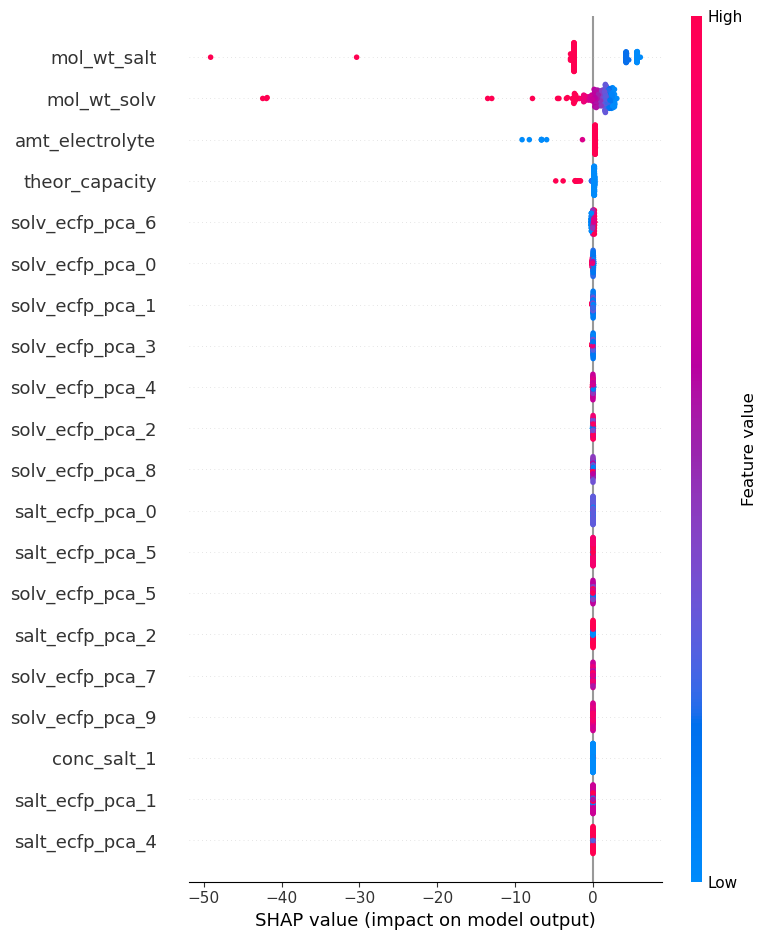

In [ ]:
# Load the pre-trained model
# model_path = 'path/to/your/trained_model.pkl'
gpr = pickle.load(open(model_names[0], 'rb'))

# Load your dataset
# X = np.load('path/to/your/dataset.npy')

# Use SHAP to explain the model
explainer = shap.KernelExplainer(gpr.predict, X)
shap_values_pair = explainer.shap_values(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_pair, X)

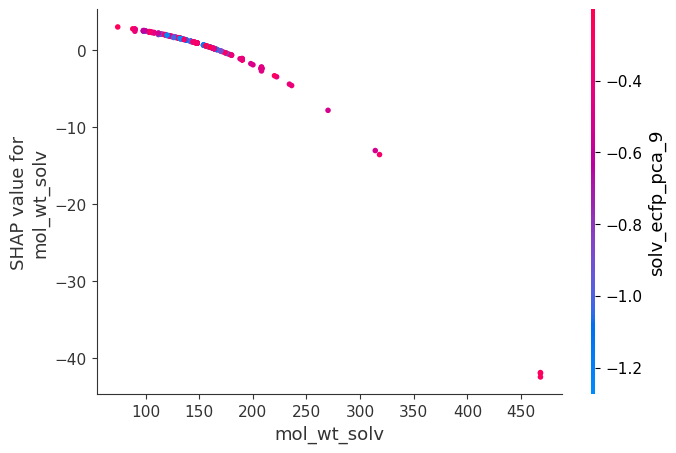

In [38]:
shap.dependence_plot("mol_wt_solv", shap_values_pair, X)

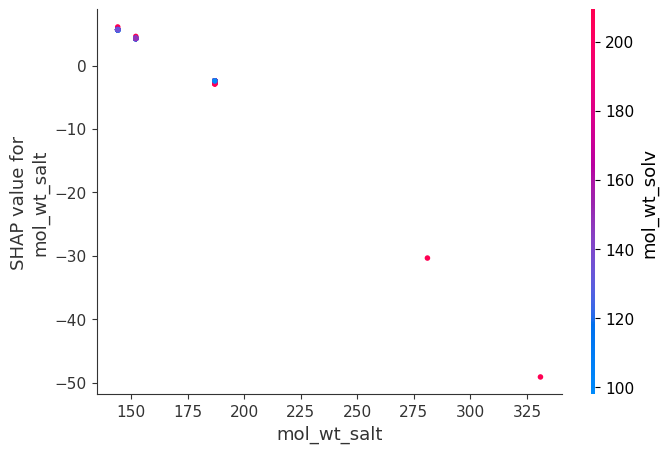

In [39]:
shap.dependence_plot("mol_wt_salt", shap_values_pair, X)

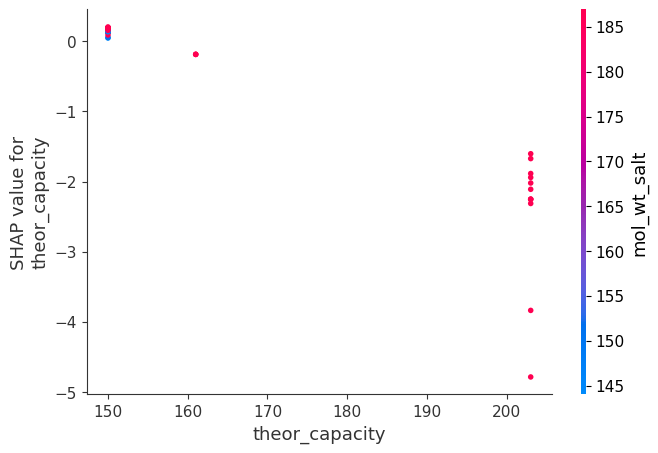

In [40]:
shap.dependence_plot("theor_capacity", shap_values_pair, X)

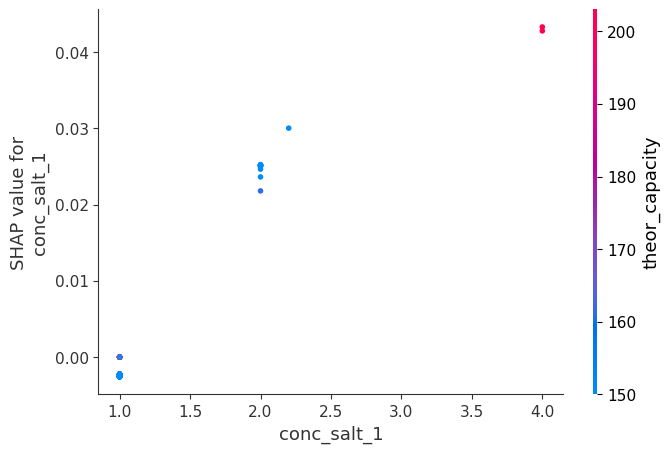

In [43]:
shap.dependence_plot("conc_salt_1", shap_values_pair, X)

#### Model: 2 (Matern)

Using 199 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/199 [00:00<?, ?it/s]

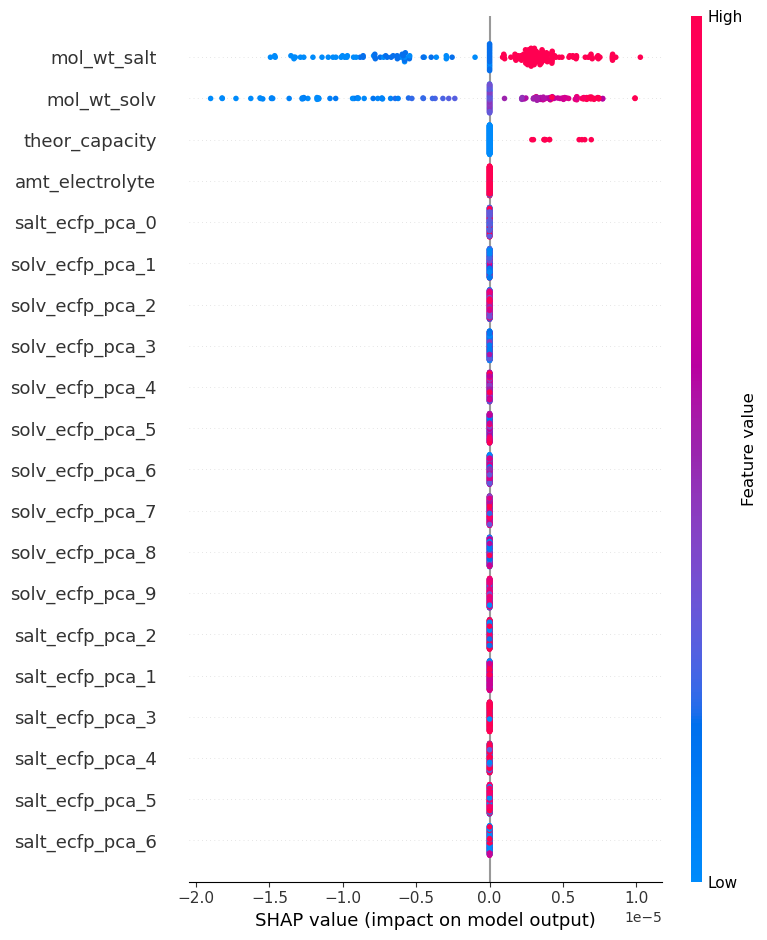

In [45]:
gpr = pickle.load(open(model_names[1], 'rb'))

# Load your dataset
# X = np.load('path/to/your/dataset.npy')

# Use SHAP to explain the model
explainer = shap.KernelExplainer(gpr.predict, X)
shap_values_mat = explainer.shap_values(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_mat, X)

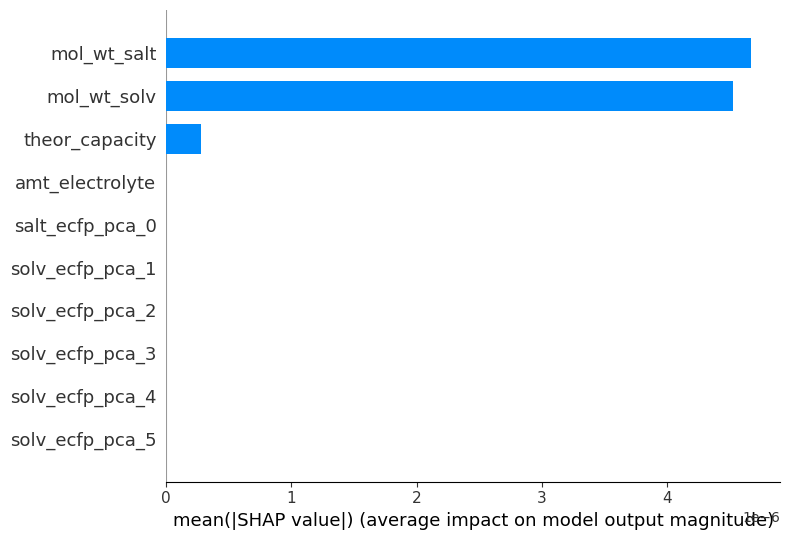

In [57]:
shap.summary_plot(shap_values_mat, X, plot_type='bar', max_display=10)

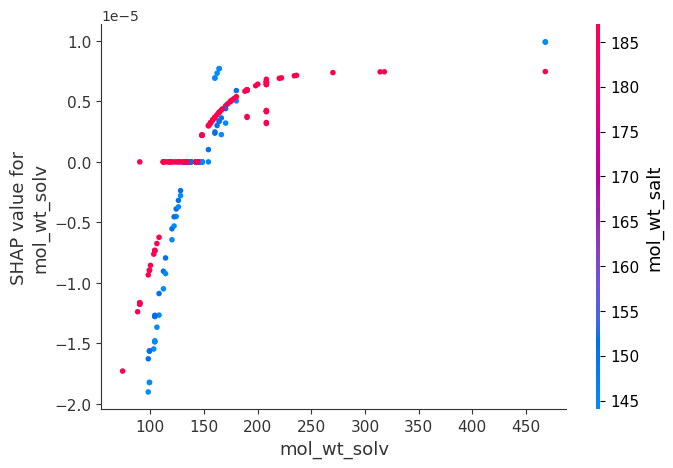

In [46]:
shap.dependence_plot("mol_wt_solv", shap_values_mat, X)

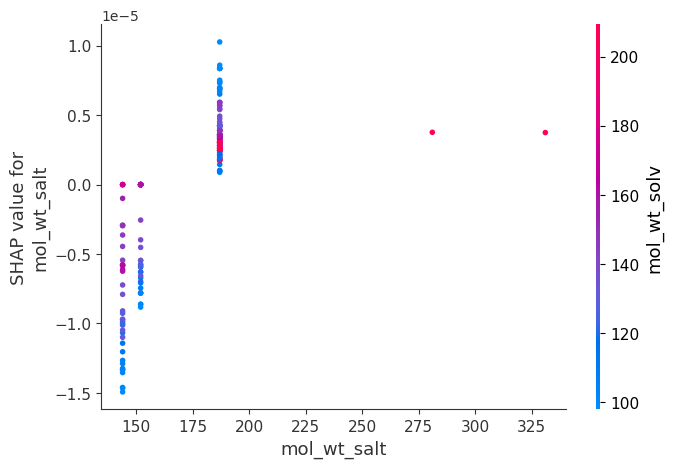

In [47]:
shap.dependence_plot("mol_wt_salt", shap_values_mat, X)

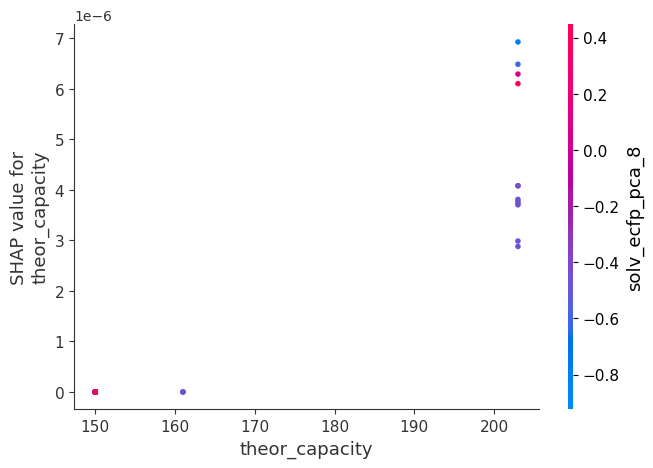

In [63]:
shap.dependence_plot("theor_capacity", shap_values_mat, X)

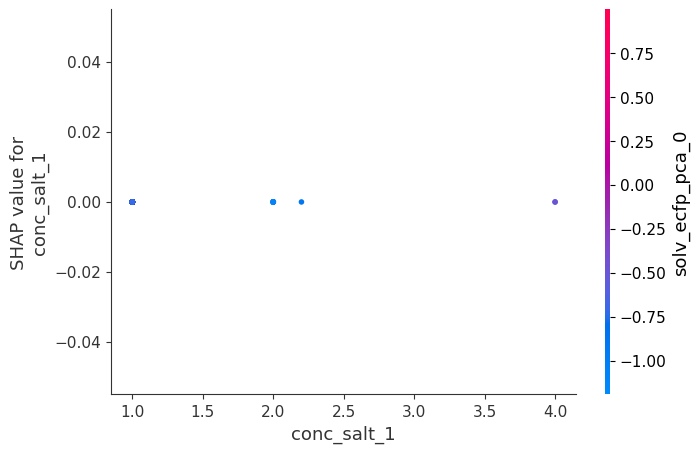

In [64]:
shap.dependence_plot("conc_salt_1", shap_values_mat, X)

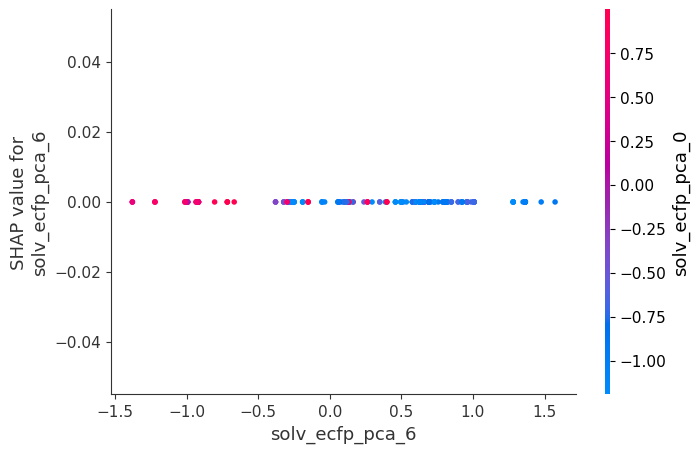

In [66]:
shap.dependence_plot("solv_ecfp_pca_6", shap_values_mat, X)

#### Model: 3 (RQ)

Using 199 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/199 [00:00<?, ?it/s]

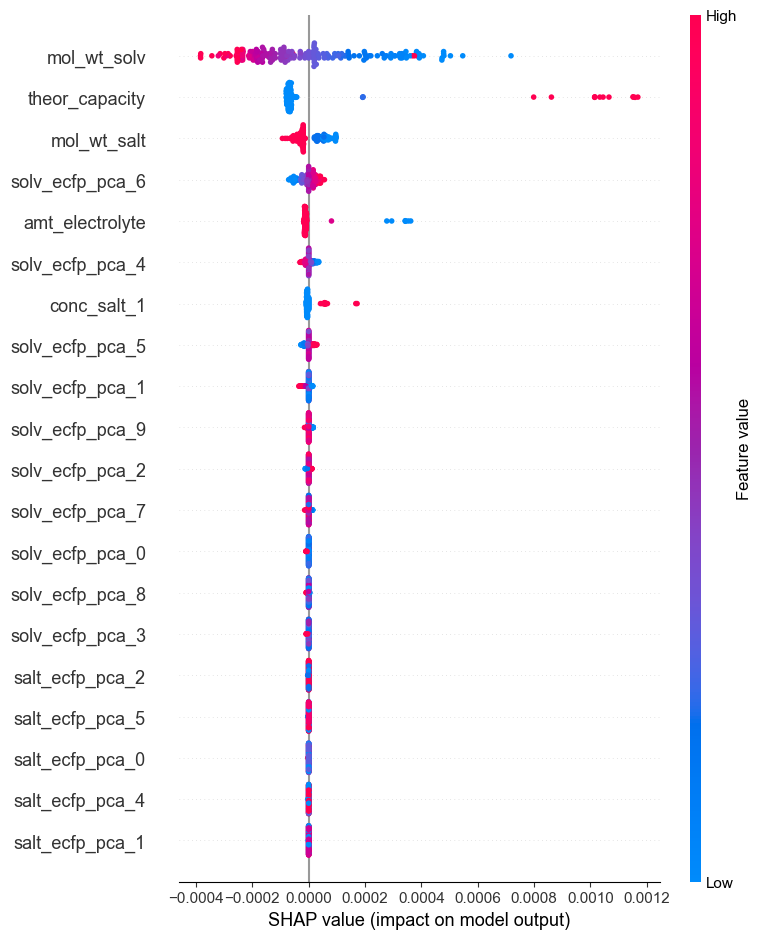

In [15]:
# Load the pre-trained model
# model_path = 'path/to/your/trained_model.pkl'
gpr = pickle.load(open(model_names[2], 'rb'))

# Load your dataset
# X = np.load('path/to/your/dataset.npy')

# Use SHAP to explain the model
explainer = shap.KernelExplainer(gpr.predict, X)
shap_values_rq = explainer.shap_values(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_rq, X)

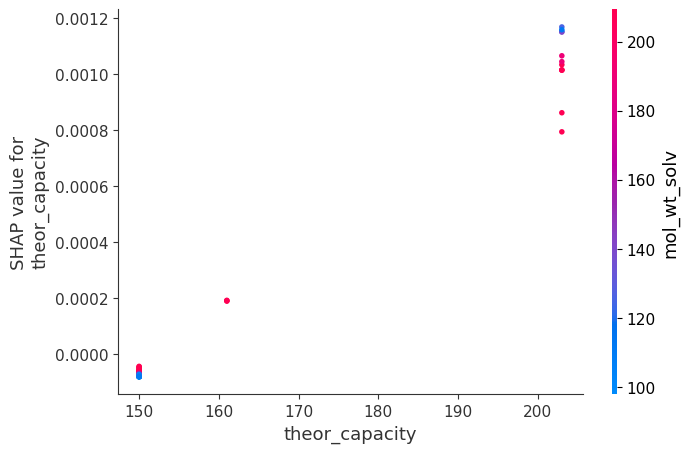

In [32]:
shap.dependence_plot("theor_capacity", shap_values_rq, X)

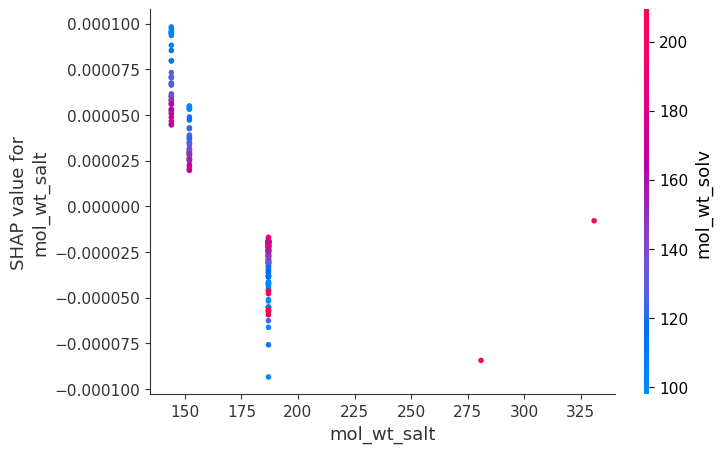

In [107]:
shap.dependence_plot("mol_wt_salt", shap_values_rq, X)

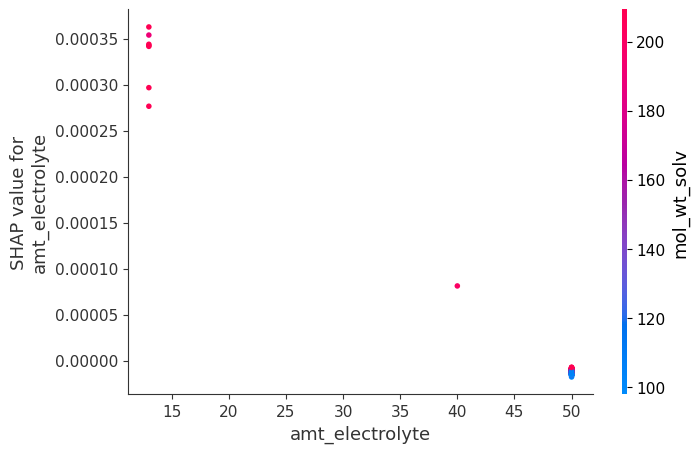

In [33]:
shap.dependence_plot("amt_electrolyte", shap_values_rq, X)

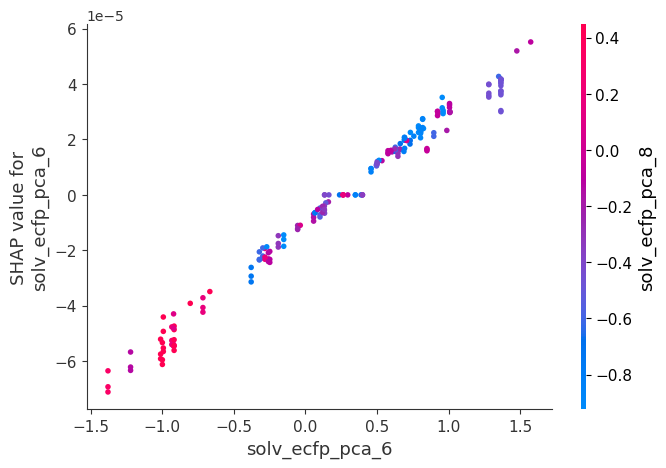

In [34]:
shap.dependence_plot("solv_ecfp_pca_6", shap_values_rq, X)

#### Model: 4 (ESS+RBF) -> not using

Using 199 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/199 [00:00<?, ?it/s]

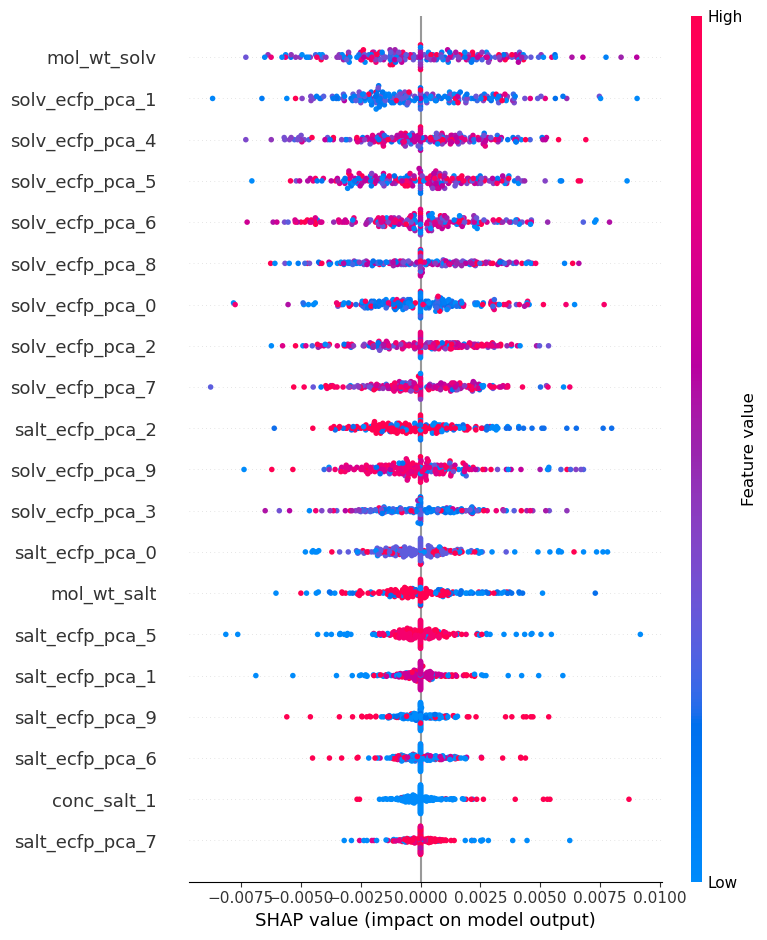

In [35]:
# Load the pre-trained model
# model_path = 'path/to/your/trained_model.pkl'
gpr = pickle.load(open(model_names[3], 'rb'))

# Load your dataset
# X = np.load('path/to/your/dataset.npy')

# Use SHAP to explain the model
explainer = shap.KernelExplainer(gpr.predict, X)
shap_values_ess = explainer.shap_values(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_ess, X)

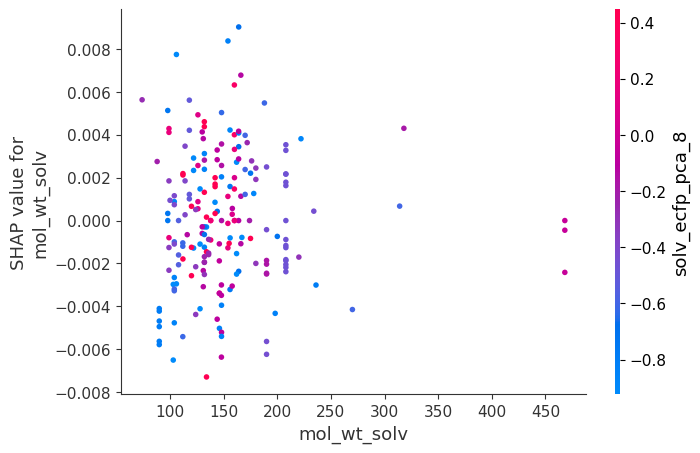

In [36]:
shap.dependence_plot("mol_wt_solv", shap_values_ess, X)

#### Final SHAP plots (using RQ surrogate model)

In [6]:
blue = (0, 0.576, 0.902) # 0, 147, 230
green = (0.349,0.745,0.306) # 89, 190, 78
red = (0.984, 0.262, 0.219) # 251, 67, 56 
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
purple = (0.839, 0.286, 0.604) # 214, 73, 1541
anvil = (0.298, 0.78, 0.77) # 76, 199, 196
dark_purple = (0.557, 0, 0.998) # 142, 0, 252
pink = (0.95, 0.78, 0.996) # 242, 199, 154
gray = (0.463,0.463,0.463) # 118, 118, 118

In [ ]:
X = df_.iloc[:,2:27]
y = df_['norm_capacity_3']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## will be using complete dataset for training
# X_test
# X

model_names = ['pairwise_iter7_051124.pkl', 'matern_iter7_051124.pkl', 'rq_iter7_051124.pkl', 'rbfexpsin_iter7_051124.pkl']

gpr = pickle.load(open(model_names[2], 'rb'))

# Load your dataset
# X = np.load('path/to/your/dataset.npy')

# Use SHAP to explain the model
explainer = shap.KernelExplainer(gpr.predict, X)
shap_values_rq = explainer.shap_values(X)

In [16]:
cols_X = X.columns
cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
shap_df = pd.DataFrame(shap_values_rq, columns=cols_shap)
shap_df

,shap_solv_ecfp_pca_0,shap_solv_ecfp_pca_1,shap_solv_ecfp_pca_2,shap_solv_ecfp_pca_3,shap_solv_ecfp_pca_4,shap_solv_ecfp_pca_5,shap_solv_ecfp_pca_6,shap_solv_ecfp_pca_7,shap_solv_ecfp_pca_8,shap_solv_ecfp_pca_9,...,shap_salt_ecfp_pca_5,shap_salt_ecfp_pca_6,shap_salt_ecfp_pca_7,shap_salt_ecfp_pca_8,shap_salt_ecfp_pca_9,shap_mol_wt_solv,shap_mol_wt_salt,shap_conc_salt_1,shap_theor_capacity,shap_amt_electrolyte
0,0.000000,0.000000,0.0,0.0,0.000009,0.000005,0.000021,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000473,-0.000052,-0.000006,-0.000071,-0.000014
1,0.000000,-0.000004,0.0,0.0,0.000029,-0.000016,0.000011,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000140,-0.000035,-0.000005,-0.000071,-0.000012
2,0.000000,0.000000,0.0,0.0,0.000031,-0.000015,0.000016,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000030,-0.000006,-0.000070,-0.000012
3,0.000000,0.000000,0.0,0.0,0.000031,-0.000014,0.000016,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000031,-0.000006,-0.000070,-0.000012
4,0.000000,0.000008,0.0,0.0,-0.000022,0.000000,0.000028,0.000000,0.0,-0.000007,...,0.0,0.0,0.0,0.0,0.0,-0.000077,-0.000028,0.000067,-0.000069,-0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,-0.000006,-0.000011,0.0,0.0,0.000008,0.000006,-0.000017,0.000012,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000056,0.000038,-0.000006,-0.000074,-0.000013
195,-0.000007,-0.000013,0.0,0.0,0.000008,0.000000,-0.000018,0.000012,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000057,0.000071,-0.000006,-0.000076,-0.000013
196,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000023,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,-0.000049,-0.000026,-0.000004,-0.000067,-0.000009
197,0.000000,0.000006,0.0,0.0,0.000013,0.000000,0.000020,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000270,-0.000043,0.000000,-0.000071,-0.000013


In [18]:
comb_df = pd.concat([X, shap_df], axis=1)
# comb_df['norm_capacity_3'] = df_['norm_capacity_3']
# comb_df['pred_norm_capacity_3'] = y_label_preds[2] ## from RQ model
comb_df

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,shap_salt_ecfp_pca_5,shap_salt_ecfp_pca_6,shap_salt_ecfp_pca_7,shap_salt_ecfp_pca_8,shap_salt_ecfp_pca_9,shap_mol_wt_solv,shap_mol_wt_salt,shap_conc_salt_1,shap_theor_capacity,shap_amt_electrolyte
0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,-0.780469,-0.407588,...,0.0,0.0,0.0,0.0,0.0,0.000473,-0.000052,-0.000006,-0.000071,-0.000014
1,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.0,0.0,0.0,0.0,0.0,0.000140,-0.000035,-0.000005,-0.000071,-0.000012
2,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000030,-0.000006,-0.000070,-0.000012
3,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000031,-0.000006,-0.000070,-0.000012
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.0,0.0,0.0,0.0,0.0,-0.000077,-0.000028,0.000067,-0.000069,-0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,0.0,0.0,0.0,0.0,0.0,0.000056,0.000038,-0.000006,-0.000074,-0.000013
195,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,0.0,0.0,0.0,0.0,0.0,0.000057,0.000071,-0.000006,-0.000076,-0.000013
196,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,-1.061449,-0.608401,...,0.0,0.0,0.0,0.0,0.0,-0.000049,-0.000026,-0.000004,-0.000067,-0.000009
197,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,-0.907013,-0.467004,...,0.0,0.0,0.0,0.0,0.0,0.000270,-0.000043,0.000000,-0.000071,-0.000013


In [98]:
comb_df.loc[comb_df['theor_capacity'] == 203][['mol_wt_salt', 'theor_capacity', 'norm_capacity_3', 'pred_norm_capacity_3']]

,mol_wt_salt,theor_capacity,norm_capacity_3,pred_norm_capacity_3
33,186.939685,203,0.736066,0.530144
34,330.941460,203,0.000522,0.064354
35,186.939685,203,0.743032,0.488424
36,280.958608,203,0.097532,0.218583
37,186.939685,203,0.000009,0.488424
38,186.939685,203,0.626675,0.488424
39,186.939685,203,0.612006,0.484402
40,186.939685,203,0.642517,0.510664
56,186.939685,203,0.718571,0.608523
57,186.939685,203,0.761182,0.724766


In [102]:
comb_df['mol_wt_solv'].min(), comb_df['mol_wt_solv'].max()

(74.07316494, 468.0426377)

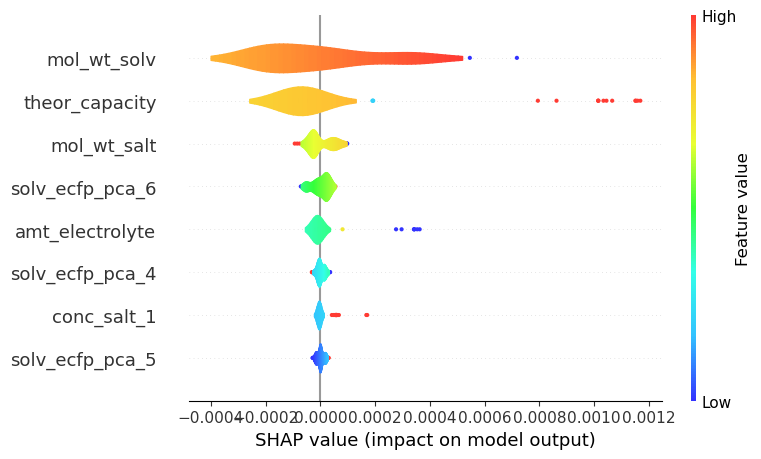

In [ ]:
## Did not not use it
# Color scheme according to origin plots
import matplotlib
fig, ax = plt.subplots(figsize=(6, 5))
c1 = '#3333FF'; c1 = mcolors.to_rgb(c1)
c2 = '#33C2FF'; c2 = mcolors.to_rgb(c2)
c3 = '#33FFE8'; c3 = mcolors.to_rgb(c3)
c4 = '#33FF3B'; c4 = mcolors.to_rgb(c4)
c5 = '#E9FF33'; c5 = mcolors.to_rgb(c5)
c6 = '#FFC133'; c6 = mcolors.to_rgb(c6)
c7 = '#FF3B33'; c7 = mcolors.to_rgb(c7)
# cmap1_or = mcolors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = mcolors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red

# Create the SHAP summary plot
shap.summary_plot(shap_values_rq, X, max_display=8, show=False, plot_type='violin', cmap=cmap1)

# Get the current axis
ax = plt.gca()

# Manually set the colors for the violin plots
for i, artist in enumerate(ax.collections):
	if isinstance(artist, matplotlib.collections.PolyCollection):
		color = cmap1(i / len(ax.collections))
		artist.set_facecolor(color)
		artist.set_edgecolor(color)

# plt.show()
# Optionally save the figure
# plt.savefig('shap_rq_b7_summary.eps', bbox_inches='tight', dpi=300)

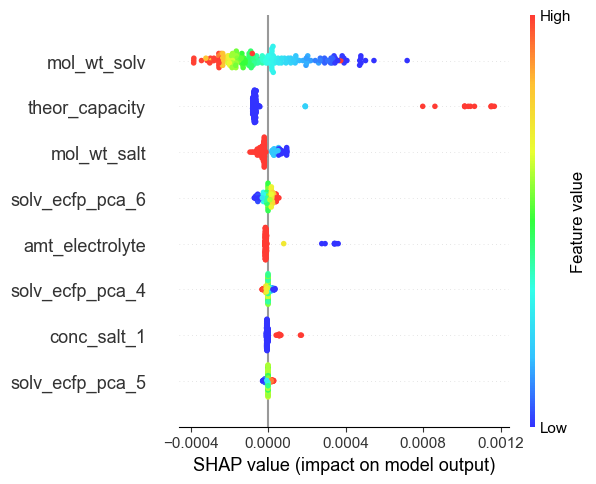

In [19]:
# import matplotlib
# fig, ax = plt.subplots(figsize=(5.5, 6))
c1 = '#3333FF'; c1 = mcolors.to_rgb(c1)
c2 = '#33C2FF'; c2 = mcolors.to_rgb(c2)
c3 = '#33FFE8'; c3 = mcolors.to_rgb(c3)
c4 = '#33FF3B'; c4 = mcolors.to_rgb(c4)
c5 = '#E9FF33'; c5 = mcolors.to_rgb(c5)
c6 = '#FFC133'; c6 = mcolors.to_rgb(c6)
c7 = '#FF3B33'; c7 = mcolors.to_rgb(c7)
# cmap1_or = mcolors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = mcolors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red

# Create the SHAP summary plot
shap.summary_plot(shap_values_rq, X, max_display=8, show=False, cmap=cmap1)

plt.xticks([-0.0004, 0.0, 0.0004, 0.0008, 0.0012])
# Adjust the figure size
plt.gcf().set_size_inches(5.5, 5)

# Optionally save the figure
# plt.savefig('shap_rq_b7_summary_111024.eps', dpi=300)
plt.savefig('shap_rq_b7_summary_120424.eps', dpi=300) ## decreasing height on 12-04-2024 to fit with other plots in Figure 2

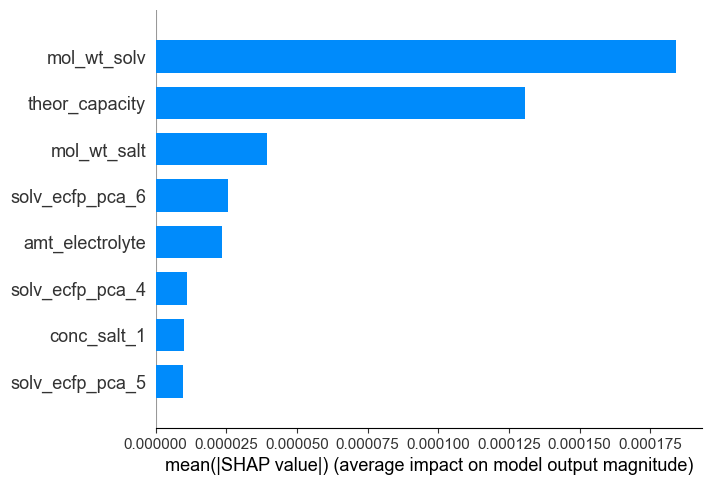

In [44]:
# fig, ax = plt.subplots(figsize=(6, 5))
shap.summary_plot(shap_values_rq, X, max_display=8, plot_type='bar', cmap=cmap1, show=False)
plt.gcf().set_size_inches(7, 5)
# plt.savefig('shap_rq_b7_summary_bar_120624.eps', dpi=300)

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


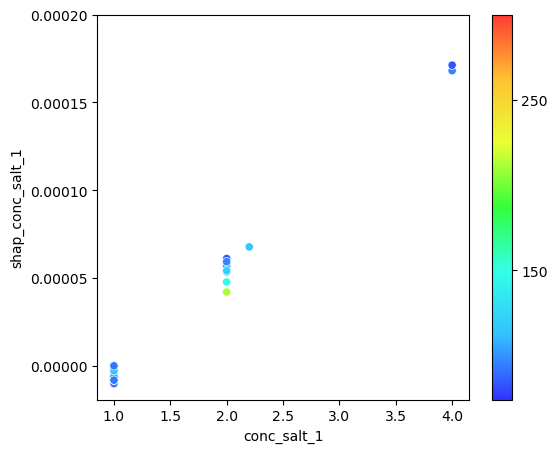

In [106]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='conc_salt_1', y='shap_conc_salt_1', data=comb_df, hue='mol_wt_solv', palette=cmap1)
# norm = plt.Normalize(comb_df['mol_wt_solv'].min(), comb_df['mol_wt_solv'].max())
norm = plt.Normalize(comb_df['mol_wt_solv'].min(), 300)
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([0.0,0.00005, 0.00010,0.00015,0.00020])
# ax.figure.colorbar(sm, ticks=[150, 250, 350, 450])
ax.figure.colorbar(sm, ticks=[150, 250, 350, 450]) ## only till 300 and not max value of 'mol_wt_solv' (next plot)
# ax.figure.colorbar(sm)
plt.savefig('shap_rq_b7_dependence_conc_salt_111024.eps', dpi=300)

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


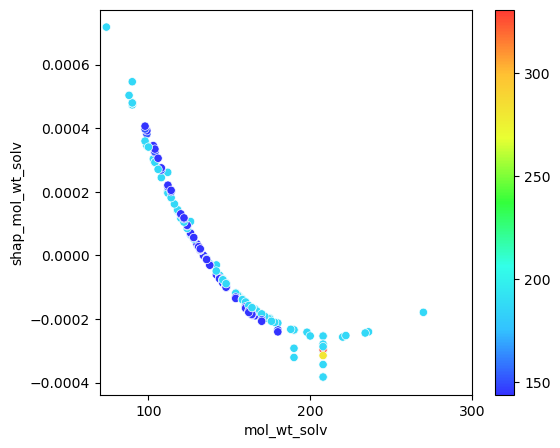

In [105]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='mol_wt_solv', y='shap_mol_wt_solv', data=comb_df, hue='mol_wt_salt', palette=cmap1)
# ax = sns.scatterplot(x='mol_wt_solv', y='shap_mol_wt_solv', data=comb_df, hue='conc_salt_1', palette=cmap1)
norm = plt.Normalize(comb_df['mol_wt_salt'].min(), comb_df['mol_wt_salt'].max())
# norm = plt.Normalize(comb_df['conc_salt_1'].min(), comb_df['conc_salt_1'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

ax.set_xlim(70, 300)
ax.set_xticks([100, 200, 300]) ## only till 300 and not max value of 'mol_wt_solv' (keeps on increasing which does not make sense)
# Remove the legend and add a colorbar
ax.get_legend().remove()
# ax.set_yticks([-2, -1, 0, 1])
ax.figure.colorbar(sm, ticks=[100, 150, 200, 250, 300])
# ax.figure.colorbar(sm, ticks=[1, 2, 3, 4])
# ax.figure.colorbar(sm)
plt.savefig('shap_rq_b7_dependence_mol_wt_solv_111024.eps', dpi=300)

In [112]:
comb_df = comb_df.sort_values(by='solv_ecfp_pca_8', ascending=False)

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


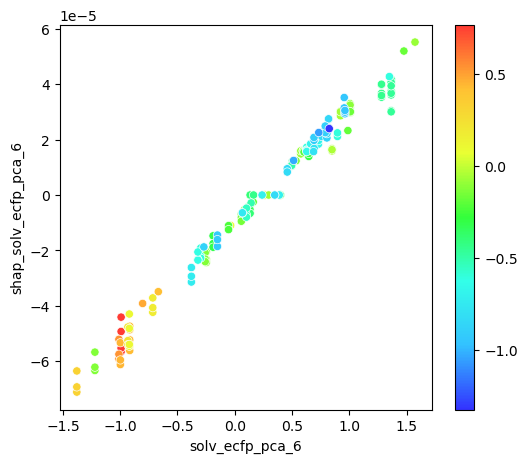

In [113]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='solv_ecfp_pca_6', y='shap_solv_ecfp_pca_6', data=comb_df, hue='solv_ecfp_pca_8', palette=cmap1)
norm = plt.Normalize(comb_df['solv_ecfp_pca_8'].min(), comb_df['solv_ecfp_pca_8'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, ticks=[-1, -0.5, 0, 0.5])
# ax.figure.colorbar(sm)
plt.savefig('shap_rq_b7_dependence_solv_ecfp_pca_6_111024.eps', dpi=300)

### Generate molecular substructures corresponding to ECFP fingerprints

In [68]:
df_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,COC1CCCCC1=O,[Li+].F[P-](F)(F)(F)(F)F,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
195,COC1CCCCC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
196,COCCS(=O)(=O)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
197,COCCSC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [24]:
# Function to get the substructures corresponding to ECFP bits -> from copilot
def get_ecfp_substructures(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, bitInfo=info)
    
    substructures = {}
    for bit, paths in info.items():
        substructures[bit] = []
        for path in paths:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, path[0])
            amap = {}
            submol = Chem.PathToSubmol(mol, env, atomMap=amap)
            substructures[bit].append(Chem.MolToSmiles(submol))
    return substructures

# 1. Prepare your list of SMILES
# smiles_list = ['CCO', 'CCN', 'CCC', 'CCCl', 'CCBr']
smiles_list = list(df_['solv_comb_sm'].unique())

# 2. Initialize data structures to store results
molecules = []
fingerprints = []
bitInfos = []
invalid_smiles = []

# 3. Iterate over the list of SMILES
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"SMILES '{smiles}' could not be parsed.")
        invalid_smiles.append(smiles)
        continue
    molecules.append(mol)
    
    # Generate Morgan fingerprint with bit information
    bitInfo = {}
    # fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bitInfo)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bitInfo) ## 1024 bit size was used for reducing ECFP to 10 features using PCA
    fingerprints.append(fingerprint)
    bitInfos.append(bitInfo)

# 4. Function to visualize substructures corresponding to bits
def visualize_bit_substructures(mol, bitInfo, bit_id):
    highlighted_atoms = set()
    for atom_idx, radius in bitInfo[bit_id]:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
        atoms = set()
        if not env:  # Handle single atom case
            atoms.add(atom_idx)
        else:
            for bond_id in env:
                bond = mol.GetBondWithIdx(bond_id)
                atoms.add(bond.GetBeginAtomIdx())
                atoms.add(bond.GetEndAtomIdx())
        highlighted_atoms.update(atoms)
    
    # Draw the molecule with highlighted atoms
    mol_copy = Chem.Mol(mol)
    drawer = Draw.MolDraw2DCairo(300, 300)
    opts = drawer.drawOptions()
    # Highlight the atoms in red
    opts.atomHighlights = {idx: (1, 0, 0) for idx in highlighted_atoms}
    drawer.DrawMolecule(mol_copy, highlightAtoms=highlighted_atoms)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()
    return img, highlighted_atoms

# 5. Map bits back to substructures for each molecule
for i, mol in enumerate(molecules):
    smiles = smiles_list[i]
    bitInfo = bitInfos[i]
    print(f"\nProcessing Molecule: {smiles}")
    
    # Get the bits that are set in the fingerprint
    on_bits = fingerprints[i].GetOnBits()
    print(f"Number of bits set: {len(on_bits)}")
    
    # For demonstration, process each bit
    for bit_id in on_bits:
        # Visualize the substructure corresponding to this bit
        img, highlighted_atoms = visualize_bit_substructures(mol, bitInfo, bit_id)
        print(f"  Bit ID: {bit_id}, Highlighted Atoms: {highlighted_atoms}")
        # Save the image to a file
        with open(f"substructures/{smiles}_bit_{bit_id}.png", 'wb') as f:
            f.write(img)
        # Optionally, add more code to analyze or process the substructures


Processing Molecule: COCCOC
Number of bits set: 8
  Bit ID: 13, Highlighted Atoms: {1, 2, 3, 4}
  Bit ID: 33, Highlighted Atoms: {0, 5}
  Bit ID: 80, Highlighted Atoms: {2, 3}
  Bit ID: 486, Highlighted Atoms: {0, 1, 2, 3, 4, 5}
  Bit ID: 695, Highlighted Atoms: {1, 4}
  Bit ID: 841, Highlighted Atoms: {0, 1, 4, 5}
  Bit ID: 893, Highlighted Atoms: {0, 1, 2, 3, 4, 5}
  Bit ID: 1005, Highlighted Atoms: {0, 1, 2, 3, 4, 5}

Processing Molecule: COCCOC(C)C
Number of bits set: 15
  Bit ID: 1, Highlighted Atoms: {5}
  Bit ID: 13, Highlighted Atoms: {1, 2, 3, 4}
  Bit ID: 33, Highlighted Atoms: {0, 6, 7}
  Bit ID: 80, Highlighted Atoms: {2, 3}
  Bit ID: 283, Highlighted Atoms: {5, 6, 7}
  Bit ID: 316, Highlighted Atoms: {3, 4, 5}
  Bit ID: 331, Highlighted Atoms: {3, 4, 5, 6, 7}
  Bit ID: 457, Highlighted Atoms: {2, 3, 4, 5, 6, 7}
  Bit ID: 486, Highlighted Atoms: {0, 1, 2, 3}
  Bit ID: 520, Highlighted Atoms: {1, 2, 3, 4, 5}
  Bit ID: 695, Highlighted Atoms: {1, 4}
  Bit ID: 841, Highlighte

#### Plot to show number of molecules having three important substructures

In [25]:
with open('substructures/114bit_sub6', 'r') as f1:
    array_sub6 = []
    for line in f1.readlines():
        # print(line)
        array_sub6.append(line.split('_')[0])
f1.close()

with open('substructures/841bit_sub4', 'r') as f2:
    array_sub4 = []
    for line in f2.readlines():
        # print(line)
        array_sub4.append(line.split('_')[0])
f2.close()

with open('substructures/1bit_sub5', 'r') as f3:
    array_sub5 = []
    for line in f3.readlines():
        # print(line)
        array_sub5.append(line.split('_')[0])
f3.close()

In [26]:
array_sub6 
# array_sub4
# str(line)[2]

['CCOCCOC(C)(C)C',
 'COC(=O)OCC(F)(F)F',
 'COC(CC(F)(F)F)OC',
 'COC(CCl)(CCl)OC',
 'COC(F)(F)C(F)Cl',
 'COC(OC)C(F)(F)F',
 'COCC(F)(F)C(F)(F)COC',
 'COCC(F)(F)C(F)(F)F',
 'COCC(F)(F)C(F)F',
 'COCCC(C)(OC)OC',
 'COCCOC(C)(C)C',
 'COCCOCC(F)(F)C(F)(F)F',
 'COCCOCC(F)(F)C(F)F',
 'COCCOCCOCC(F)(F)C(F)F',
 'COCCOCOCC(F)(F)F',
 'CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)(OC)OC',
 'CO[Si](CCC(F)(F)C(F)(F)C(F)(F)F)(OC)OC',
 'FC(F)(F)COCCOCCOCC(F)(F)F',
 'FC(F)(F)COCCOCCOCCOCC(F)(F)F',
 'O=C1OCC(C(F)(F)F)O1']

In [27]:
df_['rq_norm_capacity_3'] = y_label_preds[2]

In [160]:
len(df_['solv_comb_sm'].unique())

88

In [28]:
df_finger_sub6 = df_.query('solv_comb_sm == {}'.format(array_sub6))[['solv_comb_sm', 'norm_capacity_3', 'rq_norm_capacity_3']]
df_finger_sub6

,solv_comb_sm,norm_capacity_3,rq_norm_capacity_3
4,CCOCCOC(C)(C)C,0.026187,0.399959
11,FC(F)(F)COCCOCCOCC(F)(F)F,0.366900,0.270248
13,COCCOCC(F)(F)C(F)(F)F,0.652767,0.476053
14,COCCOCC(F)(F)C(F)(F)F,0.770547,0.476053
15,COCCOCC(F)(F)C(F)(F)F,0.700847,0.476053
16,FC(F)(F)COCCOCCOCCOCC(F)(F)F,0.477793,0.399980
17,COCCOCC(F)(F)C(F)(F)F,0.751720,0.476053
18,COCCOCC(F)(F)C(F)(F)F,0.684840,0.476053
20,COCCOCC(F)(F)C(F)F,0.816787,0.434430
21,COCCOCC(F)(F)C(F)F,0.691613,0.434430


In [29]:
df_finger_sub4 = df_.query('solv_comb_sm == {}'.format(array_sub4))[['solv_comb_sm', 'norm_capacity_3', 'rq_norm_capacity_3']]
df_finger_sub4

,solv_comb_sm,norm_capacity_3,rq_norm_capacity_3
0,COCCOC,0.276580,0.356559
1,COCCOC(C)C,0.661460,0.265441
2,COCCOCC(C)C,0.178387,0.289472
3,COCCOCC(C)C,0.216953,0.289472
7,CCCCOCCOC,0.285020,0.404838
...,...,...,...
194,COC1CCCCC1=O,0.000000,0.158539
195,COC1CCCCC1=O,0.000000,0.151038
196,COCCS(=O)(=O)F,0.264730,0.348684
197,COCCSC,0.000000,0.361483


In [30]:
df_finger_sub5 = df_.query('solv_comb_sm == {}'.format(array_sub5))[['solv_comb_sm', 'norm_capacity_3', 'rq_norm_capacity_3']]
df_finger_sub5

,solv_comb_sm,norm_capacity_3,rq_norm_capacity_3
1,COCCOC(C)C,0.661460,0.265441
2,COCCOCC(C)C,0.178387,0.289472
3,COCCOCC(C)C,0.216953,0.289472
5,CCOCCOC(C)C,0.620447,0.438206
6,CCOCCOC(C)C,0.643713,0.438206
9,CCCCOCCOC(C)C,0.566000,0.408122
20,COCCOCC(F)(F)C(F)F,0.816787,0.434430
21,COCCOCC(F)(F)C(F)F,0.691613,0.434430
39,COCCOCC(F)(F)C(F)F,0.612006,0.484402
40,COCCOCC(F)(F)C(F)F,0.642517,0.510664


In [31]:
df_finger_sub4.to_csv('substructure_4_ecfp_all_labeled.csv', index=False)
df_finger_sub5.to_csv('substructure_5_ecfp_all_labeled.csv', index=False)
df_finger_sub6.to_csv('substructure_6_ecfp_all_labeled.csv', index=False)

In [158]:
df_finger_sub6['norm_capacity_3'].mean(), df_finger_sub6['rq_norm_capacity_3'].mean()

(0.31508561742, 0.30413633493491465)

In [161]:
df_finger_sub4['norm_capacity_3'].mean(), df_finger_sub4['rq_norm_capacity_3'].mean()

(0.29975181382926824, 0.2929702879428608)

In [162]:
df_finger_sub5['norm_capacity_3'].mean(), df_finger_sub5['rq_norm_capacity_3'].mean()

(0.21334888158974358, 0.22105611884282658)

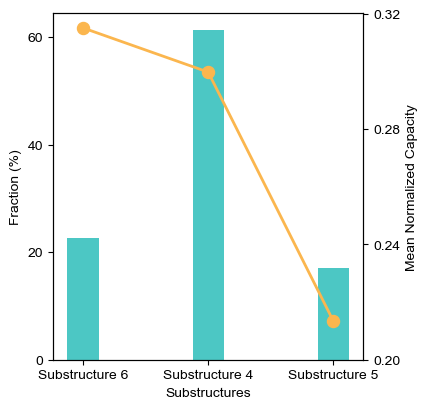

In [36]:
frac_sub = [len(array_sub6) / len(df_['solv_comb_sm'].unique()), len(array_sub4) / len(df_['solv_comb_sm'].unique()), len(array_sub5) / len(df_['solv_comb_sm'].unique())]
frac_sub = [i*100 for i in frac_sub]
norm_cap_sub = [df_finger_sub6['norm_capacity_3'].mean(), df_finger_sub4['norm_capacity_3'].mean(), df_finger_sub5['norm_capacity_3'].mean()]
fig, ax = plt.subplots(figsize=(4, 4.5))
# ax = sns.barplot(x=['Substructure 6', 'Substructure 4', 'Substructure 5'], y=frac_sub, palette='viridis')
plt.bar(['Substructure 6', 'Substructure 4', 'Substructure 5'], frac_sub, color=anvil, width=0.25)
ax2 = ax.twinx()
ax2.scatter(['Substructure 6', 'Substructure 4', 'Substructure 5'], norm_cap_sub, color=orange, marker='o', s=75)
ax2.plot(['Substructure 6', 'Substructure 4', 'Substructure 5'], norm_cap_sub, color=orange, marker=None, linewidth=2)
ax2.set_yticks([0.20, 0.24, 0.28, 0.32])
ax.set_yticks([0, 20, 40, 60])
ax.set_ylabel('Fraction (%)')
ax2.set_ylabel('Mean Normalized Capacity')
ax.set_xlabel('Substructures')
# ax.set_title('Fraction of Substructures')
# plt.savefig('frac_substructures_manu_111024.eps', dpi=300)
plt.savefig('frac_substructures_manu_120524.eps', dpi=300) ## decreasing size on 12-04-2024 to fit with other plots in Figure 2

In [198]:
df_tt = pd.read_csv('../red-embed-opt/label_all_ecfp_pca_add_feat_incl_b7_090824.csv')
df_tt

,solv_comb_sm,salt_comb_sm,batch,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23,expt_test
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.0,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.0,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,...,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.0,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,...,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.0,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,CCOCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
204,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
205,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
206,COCCCOCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


In [201]:
df_b1 = df_tt.loc[df_tt['expt_test'] == 1][['solv_comb_sm', 'salt_comb_sm', 'norm_capacity_3', 'theor_capacity', 'expt_test']]
df_b2 = df_tt.loc[df_tt['expt_test'] == 2][['solv_comb_sm', 'salt_comb_sm', 'norm_capacity_3', 'theor_capacity', 'expt_test']]
df_b3 = df_tt.loc[df_tt['expt_test'] == 3][['solv_comb_sm', 'salt_comb_sm', 'norm_capacity_3', 'theor_capacity', 'expt_test']]
df_b4 = df_tt.loc[df_tt['expt_test'] == 4][['solv_comb_sm', 'salt_comb_sm', 'norm_capacity_3', 'theor_capacity', 'expt_test']]
df_b5 = df_tt.loc[df_tt['expt_test'] == 5][['solv_comb_sm', 'salt_comb_sm', 'norm_capacity_3', 'theor_capacity', 'expt_test']]
df_b6 = df_tt.loc[df_tt['expt_test'] == 6][['solv_comb_sm', 'salt_comb_sm', 'norm_capacity_3', 'theor_capacity', 'expt_test']]
df_b7 = df_tt.loc[df_tt['expt_test'] == 7][['solv_comb_sm', 'salt_comb_sm', 'norm_capacity_3', 'theor_capacity', 'expt_test']]
df_b7

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test
199,COCCOS(=O)(=O)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.000000,150.0,7.0
200,COCCOCC(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.770667,150.0,7.0
201,COC1CCCCO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.229333,150.0,7.0
202,CCCCOCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.776667,150.0,7.0
203,CCOCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.772000,150.0,7.0
204,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.726000,150.0,7.0
205,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.442000,150.0,7.0
206,COCCCOCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.820000,150.0,7.0
207,COCCCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.000067,150.0,7.0


In [204]:
PandasTools.AddMoleculeColumnToFrame(df_b1, smilesCol='solv_comb_sm')
PandasTools.AddMoleculeColumnToFrame(df_b2, smilesCol='solv_comb_sm')
PandasTools.AddMoleculeColumnToFrame(df_b3, smilesCol='solv_comb_sm')
PandasTools.AddMoleculeColumnToFrame(df_b4, smilesCol='solv_comb_sm')
PandasTools.AddMoleculeColumnToFrame(df_b5, smilesCol='solv_comb_sm')
PandasTools.AddMoleculeColumnToFrame(df_b6, smilesCol='solv_comb_sm')
PandasTools.AddMoleculeColumnToFrame(df_b7, smilesCol='solv_comb_sm')

In [213]:
df_b2.sort_values(by='norm_capacity_3', ascending=False)

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
120,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.451913,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e04aeb0>
104,COC(CC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.375106,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e0407b0>
110,COCCOCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.039613,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x3346893c0>
109,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)F)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.010000,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x3346894a0>
119,COC(C)CC(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,0.000600,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e04ae40>
118,COC(C)CC(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,0.000600,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e04add0>
117,COC(C)CC(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.000600,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e04ad60>
105,COCCC(C)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.000007,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e040dd0>
106,COCC(C)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.000007,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e0405f0>
107,COCC(C)OC,[Li+].F[P-](F)(F)(F)(F)F,0.000007,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x334689270>


In [ ]:
df_b2_max = df_b2.loc[df_b2['norm_capacity_3'] == df_b2['norm_capacity_3'].max()] ## this is max according to 1st cell cycling which is what I added
df_b2_max

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
120,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.451913,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e04aeb0>


In [ ]:
df_b2_ = df_b2.loc[df_b2['solv_comb_sm'] == 'COC(CC(F)(F)F)OC'] ## this is max according to average of two cells cycling which is Peiyuan is reporting in paper
df_b2_

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
104,COC(CC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.375106,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e0407b0>


In [206]:
df_b3_max = df_b3.loc[df_b3['norm_capacity_3'] == df_b3['norm_capacity_3'].max()]
df_b3_max

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
121,COCCOCCOCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.549597,150.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x37e04af20>


In [208]:
df_b4_max = df_b4.loc[df_b4['norm_capacity_3'] == df_b4['norm_capacity_3'].max()]
df_b4_max

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
142,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.6343,150.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x37dca1890>


In [209]:
df_b5_max = df_b5.loc[df_b5['norm_capacity_3'] == df_b5['norm_capacity_3'].max()]
df_b5_max

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
170,COCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.7469,150.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc1510>
171,COCCCOC,[Li+].F[P-](F)(F)(F)(F)F,0.7469,150.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc1580>
172,COCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,0.7469,150.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc15f0>


In [210]:
df_b6_max = df_b6.loc[df_b6['norm_capacity_3'] == df_b6['norm_capacity_3'].max()]
df_b6_max

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
185,COC1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.827567,150.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc1ba0>


In [217]:
df_b7_max = df_b7.loc[df_b7['norm_capacity_3'] >= 0.67]
df_b7_max

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
200,COCCOCC(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.770667,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba270>
202,CCCCOCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.776667,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba350>
203,CCOCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.772000,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba3c0>
204,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.726000,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba430>
206,COCCCOCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.820000,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba510>


In [219]:
df_b_all = pd.concat([df_b2_, df_b3_max, df_b4_max, df_b5_max, df_b6_max, df_b7_max], axis=0)
df_b_all

,solv_comb_sm,salt_comb_sm,norm_capacity_3,theor_capacity,expt_test,ROMol
104,COC(CC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.375106,150.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x37e0407b0>
121,COCCOCCOCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.549597,150.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x37e04af20>
142,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.634300,150.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x37dca1890>
170,COCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.746900,150.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc1510>
171,COCCCOC,[Li+].F[P-](F)(F)(F)(F)F,0.746900,150.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc1580>
172,COCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,0.746900,150.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc15f0>
185,COC1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.827567,150.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x37dcc1ba0>
200,COCCOCC(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.770667,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba270>
202,CCCCOCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.776667,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba350>
203,CCOCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.772000,150.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x37dcba3c0>


In [220]:
smiles_list_ = list(df_b_all['solv_comb_sm'].unique())

molecules_ = []
fingerprints_ = []
bitInfos_ = []
invalid_smiles_ = []

for smiles in smiles_list_:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"SMILES '{smiles}' could not be parsed.")
        invalid_smiles_.append(smiles)
        continue
    molecules_.append(mol)
    
    # Generate Morgan fingerprint with bit information
    bitInfo = {}
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bitInfo)
    fingerprints_.append(fingerprint)
    bitInfos_.append(bitInfo)

for i, mol in enumerate(molecules_):
    smiles = smiles_list_[i]
    bitInfo = bitInfos_[i]
    print(f"\nProcessing Molecule: {smiles}")
    
    # Get the bits that are set in the fingerprint
    on_bits = fingerprints_[i].GetOnBits()
    print(f"Number of bits set: {len(on_bits)}")
    
    # For demonstration, process each bit
    for bit_id in on_bits:
        # Visualize the substructure corresponding to this bit
        img, highlighted_atoms = visualize_bit_substructures(mol, bitInfo, bit_id)
        print(f"  Bit ID: {bit_id}, Highlighted Atoms: {highlighted_atoms}")
        # Save the image to a file
        with open(f"max_batch_substructures/{smiles}_bit_{bit_id}.png", 'wb') as f:
            f.write(img)
        # Optionally, add more code to analyze or process the substructures


Processing Molecule: COC(CC(F)(F)F)OC
Number of bits set: 16
  Bit ID: 1, Highlighted Atoms: {2}
  Bit ID: 33, Highlighted Atoms: {0, 9}
  Bit ID: 80, Highlighted Atoms: {3}
  Bit ID: 114, Highlighted Atoms: {4}
  Bit ID: 170, Highlighted Atoms: {0, 1, 2, 3, 8, 9}
  Bit ID: 213, Highlighted Atoms: {3, 4, 5, 6, 7}
  Bit ID: 327, Highlighted Atoms: {0, 1, 2, 8, 9}
  Bit ID: 429, Highlighted Atoms: {4, 5, 6, 7}
  Bit ID: 527, Highlighted Atoms: {2, 3, 4, 5, 6, 7}
  Bit ID: 612, Highlighted Atoms: {8, 1, 2, 3}
  Bit ID: 695, Highlighted Atoms: {8, 1}
  Bit ID: 760, Highlighted Atoms: {0, 1, 2, 3, 4, 8, 9}
  Bit ID: 825, Highlighted Atoms: {2, 3, 4}
  Bit ID: 841, Highlighted Atoms: {0, 1, 8, 9}
  Bit ID: 904, Highlighted Atoms: {5, 6, 7}
  Bit ID: 992, Highlighted Atoms: {1, 2, 3, 4, 5, 6, 7, 8}

Processing Molecule: COCCOCCOCC(F)(F)C(F)F
Number of bits set: 22
  Bit ID: 1, Highlighted Atoms: {12}
  Bit ID: 13, Highlighted Atoms: {1, 2, 3, 4, 5, 6, 7}
  Bit ID: 26, Highlighted Atoms: {12,

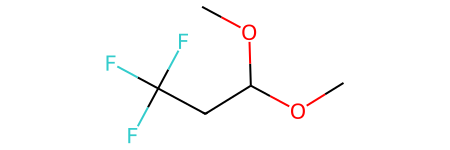

In [214]:
Chem.MolFromSmiles('COCCOCCOCC(F)(F)C(F)F')
Chem.MolFromSmiles('COCCCOCC(F)(F)C(F)F')
Chem.MolFromSmiles('COC(CC(F)(F)F)OC')

### ignore below...

**tSNE for top 5000**

In [49]:
## choosing top 5000 after removing Cl-containing compounds since they don't seem to work with AFBs!
print("Total # of Cl-containing compounds:", df_new['solv_comb_sm'].str.contains('Cl').sum())
bool_cl = df_new['solv_comb_sm'].str.contains('Cl').to_list()
cl_ind = df_new[bool_cl].index
mask = pd.Series(True, index=df_new.index)
mask.loc[cl_ind] = False
df_wo_cl = df_new[mask]
df_wo_cl

Total # of Cl-containing compounds: 114572


,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.201637,0.545168,0.171570,0.517962,0.203825,1.696190e-03,4.940562e-03,1.165527e-02,1.359631e-03,2.422279e-08
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.199837,0.545271,0.167866,0.549284,0.203073,1.434055e-03,4.412951e-03,1.087684e-02,2.009567e-03,2.343648e-08
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.200480,0.547910,0.168968,0.517618,0.203636,1.367006e-03,4.399903e-03,1.146061e-02,1.344834e-03,2.321250e-08
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.200511,0.541293,0.169337,0.545572,0.203709,1.489672e-03,4.447878e-03,1.067557e-02,1.952309e-03,2.306165e-08
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.200392,0.543853,0.168540,0.539948,0.203812,1.336109e-03,4.234071e-03,1.083573e-02,1.820138e-03,2.275773e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433423,433459,433474,433483,433501,433523,O=CC1(CCF)CCC(F)(F)C1,[Li+].F[P-](F)(F)(F)(F)F,0.294739,-1.198675,0.575193,...,0.207130,-0.117725,0.180608,-0.180838,0.208198,7.210604e-09,1.550935e-08,4.174167e-08,1.199128e-09,7.787190e-14
398228,398260,398274,398283,398299,398319,O=S1(=O)CCC(F)(F)C1,[Li+].F[P-](F)(F)(F)(F)F,0.534071,-1.136256,0.568939,...,0.203833,-0.098959,0.174729,-0.186963,0.205786,1.219153e-08,2.075621e-08,3.102791e-08,6.918394e-10,7.749745e-14
519584,519621,519637,519647,519666,519690,CC(C)C1(C=O)CCSCC1,[Li+].F[P-](F)(F)(F)(F)F,0.193192,-1.086269,0.373715,...,0.211080,-0.144552,0.187726,-0.225508,0.210240,3.481803e-09,9.803766e-09,5.211224e-08,4.774784e-10,7.638270e-14
443472,443508,443523,443532,443550,443572,O=CC1(C(F)F)CCSCC1,[Li+].F[P-](F)(F)(F)(F)F,0.279085,-1.225040,0.619722,...,0.206217,-0.118189,0.179399,-0.171043,0.207143,9.313734e-09,1.636538e-08,3.476870e-08,1.336368e-09,7.322806e-14


In [50]:
df_new_5000 = df_wo_cl.iloc[:5000,:]
df_new_5000

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.201637,0.545168,0.171570,0.517962,0.203825,0.001696,0.004941,0.011655,0.001360,2.422279e-08
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.199837,0.545271,0.167866,0.549284,0.203073,0.001434,0.004413,0.010877,0.002010,2.343648e-08
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.200480,0.547910,0.168968,0.517618,0.203636,0.001367,0.004400,0.011461,0.001345,2.321250e-08
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.200511,0.541293,0.169337,0.545572,0.203709,0.001490,0.004448,0.010676,0.001952,2.306165e-08
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.200392,0.543853,0.168540,0.539948,0.203812,0.001336,0.004234,0.010836,0.001820,2.275773e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297605,297626,297635,297640,297650,297664,CCCC1N(C)CC(=O)N1CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.234769,-0.934318,0.962222,...,0.224809,0.225026,0.203731,0.222835,0.224837,0.000069,0.000164,0.000406,0.000041,7.254832e-10
147914,147930,147937,147940,147947,147956,CCN1CCCN(CCOC)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.543175,-0.614667,1.028170,...,0.224031,0.211942,0.204031,0.266617,0.223375,0.000092,0.000175,0.000336,0.000076,7.254654e-10
963865,963925,963951,963967,963997,964035,COCCCOCCOCCOCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.769474,-0.981440,0.921684,...,0.217873,0.235127,0.198879,0.275501,0.215363,0.000059,0.000160,0.000384,0.000057,7.253915e-10
49157,49164,49168,49170,49173,49177,COOCCC(C)(OC)OOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.836628,-1.405554,0.932876,...,0.199579,0.317544,0.165570,0.240142,0.204181,0.000077,0.000176,0.000312,0.000015,7.253737e-10


In [ ]:
# df_unlabel_uniq_ = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_unlabel_uniq_

In [51]:
df_comb_tsne = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,-0.272648,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414


In [52]:
list_suggest_bool = df_comb_tsne['solv_comb_sm'].isin(df_new_5000['solv_comb_sm'])
sugg_ind = [i for i in range(len(list_suggest_bool)) if list_suggest_bool[i] == True]
list_label_pool = df_comb_tsne['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
# sugg_ind_1 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2))]
# sugg_ind_2 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2), len(sugg_ind))]
df_comb_tsne['database'] = 'unlabel'
# df_comb_tsne.loc[sugg_ind_1, 'database'] = 'sugg_5th_peiyuan'
# df_comb_tsne.loc[sugg_ind_2, 'database'] = 'sugg_5th_ritesh'
df_comb_tsne.loc[sugg_ind, 'database'] = 'sugg_all'
df_comb_tsne.loc[label_ind, 'database'] = 'label'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [54]:
len(sugg_ind)
# sugg_ind
# df_comb_tsne['database'].unique()
df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
# df_comb_tsne.loc[df_comb_tsne['database'] == 'label']

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
427,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,94.043008,186.939685,1.0,0.0,150,50,2,20.200350,24.282938,sugg_all
1155,COCCO[Al],[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.843809,-0.989662,1.069399,-0.365416,-0.311995,0.308275,0.678411,0.599304,...,102.026143,186.939685,1.0,0.0,150,50,2,20.138859,24.319561,sugg_all
1227,COCCB=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801731,-1.105580,1.083006,-0.354707,-0.315271,0.212797,0.668411,0.618927,...,86.053910,186.939685,1.0,0.0,150,50,2,19.959679,23.882128,sugg_all
1319,COCCOOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.867386,-1.041068,1.083540,-0.400942,-0.225466,0.304233,0.783784,0.599485,...,110.037922,186.939685,1.0,0.0,150,50,2,20.315548,24.234709,sugg_all
1382,COCCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.046620,-1.064656,0.993638,-0.042687,-0.413475,0.534219,0.629863,0.690217,...,102.068080,186.939685,1.0,0.0,150,50,2,21.194408,28.572851,sugg_all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385578,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,188.141244,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_all
385674,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,170.130680,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_all
385865,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,188.141244,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_all
386711,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,185.141579,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_all


cluster regions rather than assigning randomly

In [55]:
df_comb_tsne_sugg = df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
X_comb_tsne = df_comb_tsne_sugg.iloc[:,-3:-1]
X_comb_tsne

,TSNE_0,TSNE_1
427,20.200350,24.282938
1155,20.138859,24.319561
1227,19.959679,23.882128
1319,20.315548,24.234709
1382,21.194408,28.572851
...,...,...
385578,-21.946915,-9.196156
385674,-21.917328,-9.234112
385865,28.366770,-27.364807
386711,-25.198235,1.801201


In [82]:
kmeans = KMeans(random_state=0).fit(X_comb_tsne) ## using # of clusters found by kmeans method

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

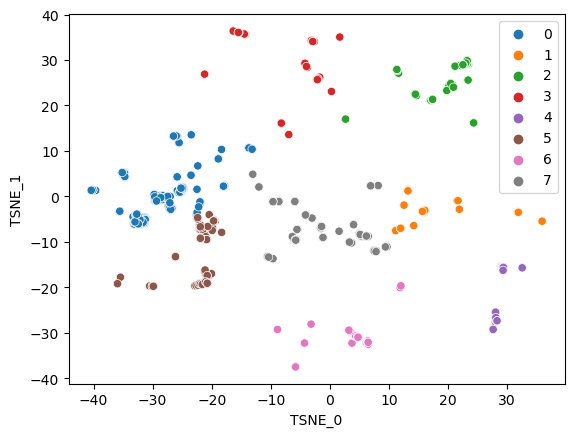

In [83]:
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

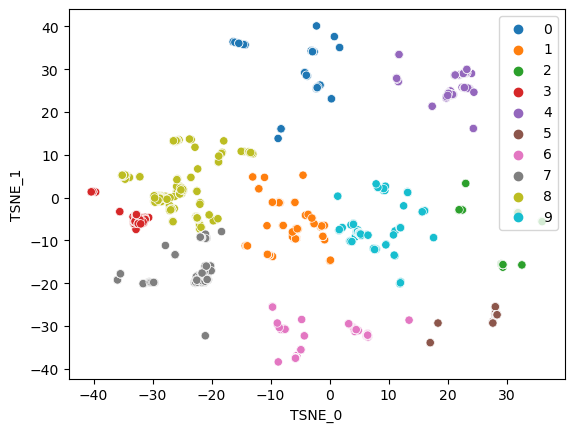

In [56]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_comb_tsne) ## fixing # of clusters to 10
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [57]:
row_label = df_comb_tsne.loc[df_comb_tsne['database'] == 'label']
df_comb_tsne_sugg['database'] = [('sugg_7th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_comb_tsne_ = pd.concat([row_label, df_comb_tsne_sugg], axis=0)
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3841/21005261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_tsne_sugg['database'] = [('sugg_7th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,468.042638,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
3279,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,104.083730,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,88.088815,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385578,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,188.141244,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_7th_7
385674,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,170.130680,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_7th_7
385865,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,188.141244,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_7th_5
386711,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,185.141579,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_7th_8


In [58]:
df_new_5000['solv_comb_sm'] = df_new_5000['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df_new_5000

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3841/4264978177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_5000['solv_comb_sm'] = df_new_5000['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))


,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.201637,0.545168,0.171570,0.517962,0.203825,0.001696,0.004941,0.011655,0.001360,2.422279e-08
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.199837,0.545271,0.167866,0.549284,0.203073,0.001434,0.004413,0.010877,0.002010,2.343648e-08
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.200480,0.547910,0.168968,0.517618,0.203636,0.001367,0.004400,0.011461,0.001345,2.321250e-08
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.200511,0.541293,0.169337,0.545572,0.203709,0.001490,0.004448,0.010676,0.001952,2.306165e-08
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.200392,0.543853,0.168540,0.539948,0.203812,0.001336,0.004234,0.010836,0.001820,2.275773e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297605,297626,297635,297640,297650,297664,CCCC1N(C)CC(=O)N1CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.234769,-0.934318,0.962222,...,0.224809,0.225026,0.203731,0.222835,0.224837,0.000069,0.000164,0.000406,0.000041,7.254832e-10
147914,147930,147937,147940,147947,147956,CCN1CCCN(CCOC)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.543175,-0.614667,1.028170,...,0.224031,0.211942,0.204031,0.266617,0.223375,0.000092,0.000175,0.000336,0.000076,7.254654e-10
963865,963925,963951,963967,963997,964035,COCCCOCCOCCOCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.769474,-0.981440,0.921684,...,0.217873,0.235127,0.198879,0.275501,0.215363,0.000059,0.000160,0.000384,0.000057,7.253915e-10
49157,49164,49168,49170,49173,49177,COOCCC(C)(OC)OOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.836628,-1.405554,0.932876,...,0.199579,0.317544,0.165570,0.240142,0.204181,0.000077,0.000176,0.000312,0.000015,7.253737e-10


In [59]:
df_new_5000['rank'] = [i for i in range(1,5001)]
df_comb_tsne_ = df_comb_tsne_.merge(df_new_5000[['solv_comb_sm', 'salt_comb_sm', 'rank']], on=['solv_comb_sm', 'salt_comb_sm'], how='left')
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3841/694021055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_5000['rank'] = [i for i in range(1,5001)]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_7th_7,578.0
4483,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_7th_7,4264.0
4484,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_7th_5,3241.0
4485,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_7th_8,2496.0


In [64]:
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COCCOCC(F)(OC)C(F)(F)F']
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COCCOCOCCF']
# df_comb_tsne_.loc[df_comb_tsne_['rank'] == 4196]
df_comb_tsne_['rank'].sort_values()
# df_new_5000['rank'].sort_values()
# np.where(df_comb_tsne_['rank'].isna)

3944    1.0
2079    2.0
3309    3.0
1999    4.0
1876    5.0
       ... 
1308    NaN
1825    NaN
2385    NaN
4424    NaN
4452    NaN
Name: rank, Length: 4487, dtype: float64

In [65]:
df_comb_tsne_.to_csv('iter_7_top5000_sugg_ei_unique_explore.csv')

In [66]:
df_comb_tsne['database'].unique()
df_comb_tsne_['database'].unique()
df_comb_tsne_.shape

(4487, 33)

Interactive tSNE plot (Himi's code)

In [67]:
## pick only rows for label, sugg_2nd_peiyuan, and sugg_2nd_ritesh -> not using it but rather clusters from kmeans
# df_comb_tsne__ = df_comb_tsne_.loc[df_comb_tsne['database'] != 'unlabel'] ## somehow this is not working
df_comb_tsne__ = df_comb_tsne_.copy()
df_comb_tsne__

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_7th_7,578.0
4483,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_7th_7,4264.0
4484,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_7th_5,3241.0
4485,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_7th_8,2496.0


In [68]:
# df_comb_tsne__['database'].values.tolist()
df_comb_tsne__['database'].unique()

array(['label', 'sugg_7th_4', 'sugg_7th_6', 'sugg_7th_1', 'sugg_7th_0',
       'sugg_7th_7', 'sugg_7th_8', 'sugg_7th_2', 'sugg_7th_3',
       'sugg_7th_9', 'sugg_7th_5'], dtype=object)

In [69]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_comb_tsne__,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_comb_tsne__.solv]
smile = df_comb_tsne__['solv_comb_sm'].values.tolist()
database_class = df_comb_tsne__['database'].values.tolist()
ind = df_comb_tsne__.index.values.tolist()
rank = df_comb_tsne__['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, rank=rank, color=df_comb_tsne__['database'].map({'sugg_7th_0':'cyan', 'sugg_7th_1':'orange', 'sugg_7th_2':'gray',
                                                                                                                                                                                       'sugg_7th_3':'teal', 'sugg_7th_4':'green', 'sugg_7th_5':'yellow', 
                                                                                                                                                                                       'sugg_7th_6':'red', 'sugg_7th_7':'purple', 'sugg_7th_8':'lime',
                                                                                                                                                                                       'sugg_7th_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 from model)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_051124_explore.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-7/interactive_map_sugg_al_051124_explore.html'

**Finding from top 5000 predictions: exploit**

In [70]:
df_exploit = df_unlabel_.copy()
df_exploit['norm_capacity_3_avg_pred'] = df_exploit[['norm_capacity_3_pair', 'norm_capacity_3_matern', 'norm_capacity_3_rq', 'norm_capacity_3_rbfexpsin']].mean(axis=1)
bool_cl_exp = df_exploit['solv_comb_sm'].str.contains('Cl').to_list()
cl_ind_exp = df_exploit[bool_cl_exp].index
mask_exp = pd.Series(True, index=df_exploit.index)
mask_exp.loc[cl_ind_exp] = False
df_exploit_wo_cl = df_exploit[mask_exp]
df_exploit_wo_cl

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.037666,0.192014,-0.054267,0.217417,5.558162e-07,1.240826e-06,0.000007,9.670306e-08,9.654864e-12,-0.011331
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,-0.003274,0.203546,-0.001456,0.226214,1.075332e-06,1.891838e-06,0.000007,7.229094e-07,1.160980e-11,-0.010513
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,-0.047665,0.209669,-0.162093,0.227823,1.044421e-07,3.739091e-07,0.000005,2.640350e-08,5.514583e-12,-0.118091
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.096361,0.178639,0.059433,0.209897,2.954488e-06,4.279159e-06,0.000008,5.715265e-07,1.833054e-11,0.082888
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.025149,0.196441,-0.091247,0.219417,4.897230e-07,1.155365e-06,0.000007,5.155232e-08,1.000300e-11,-0.031123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,-0.105749,0.224092,-0.245697,0.237513,3.898570e-08,3.090369e-07,0.000005,1.217796e-08,4.965443e-12,-0.187580
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,-0.066847,0.239166,-0.056383,0.248100,4.190717e-07,3.851784e-06,0.000025,1.544176e-06,2.846834e-11,-0.088684
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,-0.051867,0.230982,-0.089544,0.243065,3.834876e-07,2.683026e-06,0.000020,5.546731e-07,2.216600e-11,-0.086094
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,-0.087810,0.249035,-0.192402,0.257395,4.490211e-08,1.769142e-06,0.000031,2.713660e-07,2.954952e-11,-0.185245


In [71]:
df_exploit_5000 = df_exploit_wo_cl.sort_values(by=['norm_capacity_3_avg_pred'], ascending=False).iloc[:5000,:]
df_exploit_5000['rank'] = [i for i in range(1,5001)]
df_exploit_5000

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred,rank
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.167866,0.549284,0.203073,0.001434,0.004413,0.010877,0.002010,2.343648e-08,0.535321,1
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.169337,0.545572,0.203709,0.001490,0.004448,0.010676,0.001952,2.306165e-08,0.533883,2
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.171570,0.517962,0.203825,0.001696,0.004941,0.011655,0.001360,2.422279e-08,0.532022,3
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.168540,0.539948,0.203812,0.001336,0.004234,0.010836,0.001820,2.275773e-08,0.529714,4
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.168968,0.517618,0.203636,0.001367,0.004400,0.011461,0.001345,2.321250e-08,0.526424,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262283,262303,262311,262315,262325,262339,COCCCOCCCC(=O)C(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.056247,-0.101243,1.279981,...,0.190983,0.281103,0.212861,0.000063,0.000168,0.000491,0.000054,8.805505e-10,0.272041,4996
17288,17289,17291,17292,17293,17295,CCOP(=O)(OCC)OCC(C)(C)COC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.003716,-1.090308,0.969682,...,0.170233,0.242811,0.203493,0.000039,0.000117,0.000318,0.000015,6.098457e-10,0.272030,4997
43105,43111,43115,43117,43119,43123,COCC(OC)(OC=O)OC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.838175,-0.847159,1.135963,...,0.161836,0.266177,0.199026,0.000027,0.000080,0.000182,0.000017,3.957002e-10,0.272028,4998
65864,65872,65877,65879,65883,65888,CCP(=O)(OC)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.835452,-1.199883,0.893429,...,0.163275,0.281870,0.199743,0.000029,0.000077,0.000154,0.000024,3.612868e-10,0.272018,4999


In [72]:
df_tsne_exploit = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
list_exploit_bool = df_tsne_exploit['solv_comb_sm'].isin(df_exploit_5000['solv_comb_sm'])
exploit_ind = [i for i in range(len(list_exploit_bool)) if list_exploit_bool[i] == True]
list_label_pool = df_tsne_exploit['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
df_tsne_exploit['database'] = 'unlabel'
df_tsne_exploit.loc[exploit_ind, 'database'] = 'exploit'
df_tsne_exploit.loc[label_ind, 'database'] = 'label'
df_tsne_exploit

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [73]:
df_tsne_exploit_sugg = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'exploit']
# X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-3:-1]
# kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
# sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [74]:
# df_tsne_exploit_sugg['norm_capacity_3_avg_pred'] = df_exploit_10000['norm_capacity_3_avg_pred']
df_tsne_exploit_sugg = df_tsne_exploit_sugg.merge(df_exploit_5000[['solv_comb_sm', 'norm_capacity_3_avg_pred', 'rank']], on='solv_comb_sm', how='left')
df_tsne_exploit_sugg

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred,rank
0,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,1.0,0.0,150,50,2,20.200350,24.282938,exploit,0.361556,963
1,CCCOOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.920924,-1.603036,0.550274,0.249128,-0.250719,0.486272,0.282188,0.202565,...,1.0,0.0,150,50,2,1.736852,34.990818,exploit,0.272308,4969
2,[CH2]CCOOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.653605,-1.424194,0.878123,-0.406314,-0.163474,0.121483,0.449710,0.405105,...,1.0,0.0,150,50,2,-20.417168,-4.034942,exploit,0.319932,2059
3,COP(=O)(OC)OCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.621001,-1.115459,1.065245,-0.408802,0.071975,0.005767,0.326389,0.238781,...,1.0,0.0,150,50,2,-8.799691,-38.527060,exploit,0.282854,4145
4,CCOP(=O)(OCC)OCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.104998,-0.671211,1.004061,0.135798,-0.179604,0.467863,0.406747,0.484254,...,1.0,0.0,150,50,2,28.083122,-25.441036,exploit,0.276050,4683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,COCCCS(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.854245,-1.533978,0.921179,-0.305305,-0.172969,0.520020,1.193371,0.510727,...,1.0,0.0,150,50,2,31.906532,-3.521527,exploit,0.279934,4361
4992,CCCOCCOCCCOCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.877738,-1.596169,0.522391,0.412222,-0.835663,1.200644,0.817318,0.236686,...,1.0,0.0,150,50,2,-35.143620,5.230699,exploit,0.286137,3905
4993,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,1.0,0.0,150,50,2,-21.946915,-9.196156,exploit,0.341674,1358
4994,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,1.0,0.0,150,50,2,-21.917328,-9.234112,exploit,0.281449,4240


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

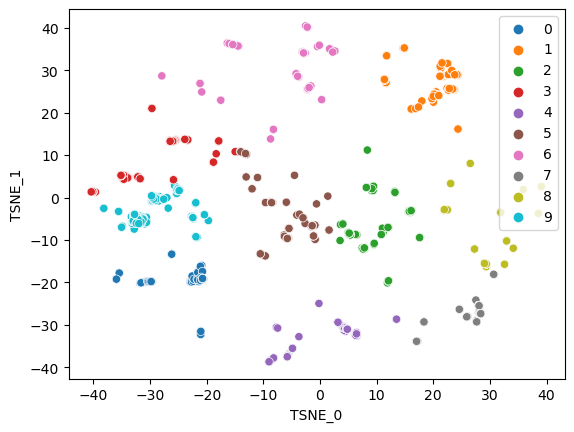

In [75]:
X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-5:-3]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [76]:
row_label = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'label']
df_tsne_exploit_sugg['database'] = [('exploit_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_tsne_exploit_ = pd.concat([row_label, df_tsne_exploit_sugg], axis=0)
df_tsne_exploit_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred,rank
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN,NaN
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN,NaN
3279,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN,NaN
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN,NaN
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,COCCCS(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.854245,-1.533978,0.921179,-0.305305,-0.172969,0.520020,1.193371,0.510727,...,1.0,0.0,150,50,2,31.906532,-3.521527,exploit_8,0.279934,4361.0
4992,CCCOCCOCCCOCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.877738,-1.596169,0.522391,0.412222,-0.835663,1.200644,0.817318,0.236686,...,1.0,0.0,150,50,2,-35.143620,5.230699,exploit_3,0.286137,3905.0
4993,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,1.0,0.0,150,50,2,-21.946915,-9.196156,exploit_9,0.341674,1358.0
4994,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,1.0,0.0,150,50,2,-21.917328,-9.234112,exploit_9,0.281449,4240.0


In [77]:
len(kmeans.labels_)
# len(row_label)

4996

In [78]:
df_tsne_exploit_['norm_capacity_3_avg_pred']

1050         NaN
2373         NaN
3279         NaN
4139         NaN
5684         NaN
          ...   
4991    0.279934
4992    0.286137
4993    0.341674
4994    0.281449
4995    0.292158
Name: norm_capacity_3_avg_pred, Length: 5137, dtype: float64

In [79]:
df_tsne_exploit_.to_csv('iter_7_top5000_sugg_ei_unique_exploit.csv', index=False)

In [80]:
df_tsne_exploit_['database'].unique()

array(['label', 'exploit_1', 'exploit_6', 'exploit_9', 'exploit_4',
       'exploit_7', 'exploit_8', 'exploit_5', 'exploit_0', 'exploit_2',
       'exploit_3'], dtype=object)

In [81]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_tsne_exploit_,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_tsne_exploit_.solv]
smile = df_tsne_exploit_['solv_comb_sm'].values.tolist()
database_class = df_tsne_exploit_['database'].values.tolist()
ind = df_tsne_exploit_.index.values.tolist()
pred = ([0.0]*110) + [round(val, 3) for val in df_tsne_exploit_['norm_capacity_3_avg_pred'].iloc[110:].values.tolist()]
rank = df_tsne_exploit_['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_tsne_exploit_['TSNE_0'], y=df_tsne_exploit_['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, pred=pred, rank=rank, color=df_tsne_exploit_['database'].map({'exploit_0':'cyan', 'exploit_1':'orange', 'exploit_2':'gray',
                                                                                                                                                                                       'exploit_3':'teal', 'exploit_4':'green', 'exploit_5':'yellow', 
                                                                                                                                                                                       'exploit_6':'red', 'exploit_7':'purple', 'exploit_8':'lime',
                                                                                                                                                                                       'exploit_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Prediction: @pred </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 predictions)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_7_051124_exploit.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-7/interactive_map_sugg_al_7_051124_exploit.html'